<h1 align="center"> Telecom Case Study </h1>

**Importing the required libraries**

In [1]:
# Importing the libraries
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

**User defined functions for processing**

In [2]:
# User defined functions
def check_cif(data) -> pd.DataFrame:
    vif = pd.DataFrame()
    vif['Features'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def missing_percent_data(df: pd.DataFrame, greater_than_zero=False) -> pd.DataFrame:
    data = round((df.isna().sum()/df.shape[0]) * 100, 2).reset_index()
    data.columns = ["Columns", "Percentage"]
    if greater_than_zero:
        data = data[data.Percentage!=0]
    return data

In [3]:
# Importing dataset
churn_data = pd.read_csv("./telecom_churn_data.csv")
churn_data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.385  ...            0        1.0        1.0   
1            9/30/2014   34.047  ...            0        NaN        1.0   
2            9/30/2014  167.690  ...            0        NaN        NaN   
3            9/30/2014  221.338  ...            0        NaN        NaN   
4            9/30/2014  261.636  ...            0        0.0        NaN   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0        1.0        NaN   968        30.4         0.0      101.20        3.58  
1        1.0        NaN  1006         0.0         0.0        0.00        0.00  
2        NaN        1.0  1103         0.0         0.0        4.17        0.00  
3        NaN        NaN  2491         0.0         0.0        0.00        0.00  
4        NaN        NaN  1526         0.0         0.0        0.00        0.00  

[5 rows x 226 columns]

In [4]:
churn_data["Churn"] = np.where((((churn_data['total_ic_mou_9']==0) | (churn_data['total_og_mou_9']==0)) & ((churn_data['vol_2g_mb_9']==0) | (churn_data['vol_3g_mb_9']==0))), 1, 0)

In [5]:
churn_data['Churn'].value_counts(normalize=True)

0    0.865939
1    0.134061
Name: Churn, dtype: float64

In [6]:
churn_data[["total_ic_mou_9", "total_og_mou_9", "vol_2g_mb_9", "vol_3g_mb_9"]]

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9
0                0.00            0.00         0.00         0.00
1              188.04           72.11         0.00         0.00
2              517.74          124.94         0.00         8.42
3              305.38          362.54         0.00         0.00
4              205.31          104.59         0.00         0.00
...               ...             ...          ...          ...
99994          154.43           27.14         0.00         0.00
99995          108.84          106.41         0.00         0.00
99996            0.00            0.00         0.00         0.00
99997            2.21            0.00        85.67      4177.14
99998            0.00            0.00         0.00         0.00

[99999 rows x 4 columns]

In [7]:
churn_data['total_ic_mou_9'].max()

10796.59

In [8]:
#(ic | og) & (2g | 3g)

In [9]:
churn_data['Churn'].value_counts(normalize=True)

0    0.865939
1    0.134061
Name: Churn, dtype: float64

**Importing the dataset**

In [10]:
# Sahpe check of the dataset
churn_data.shape

(99999, 227)

**Missing data percentage dataframe**

In [11]:
missing_data = missing_percent_data(churn_data)

Columns to be removed which has hogh percenteage of missing values. <br><br>
We have chosen 8% because there is a spike in missing percentage values from 8% to ~75%

In [12]:
# To be reomved columns
remove_cols = missing_data[missing_data.Percentage > 8]["Columns"]

In [13]:
remove_cols.values

array(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6',
       'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8', 'av_rech_amt_data_9', 'arpu_3g_6',
       'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7',
       'arpu_2g_8', 'arpu_2g_9', 'night_pck_user_6', 'night_pck_user_7',
       'night_pck_user_8', 'night_pck_user_9', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'fb_user_9'], dtype=object)

In [14]:
churn_data.drop(labels=remove_cols.values, inplace=True, axis=1)

In [15]:
churn_data.shape

(99999, 187)

In [16]:
#tag_churn(col="Churn")

In [17]:
churn_data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  \
0            9/30/2014  197.385  ...            0            0            0   
1            9/30/2014   34.047  ...            0            0            0   
2            9/30/2014  167.690  ...            0            0            0   
3            9/30/2014  221.338  ...            0            0            0   
4            9/30/2014  261.636  ...            0            0            0   

   sachet_3g_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  Churn  
0            0   968        30.4         0.0      101.20        3.58      1  
1            0  1006         0.0         0.0        0.00        0.00      0  
2            0  1103         0.0         0.0        4.17        0.00      0  
3            0  2491         0.0         0.0        0.00        0.00      0  
4            0  1526         0.0         0.0        0.00        0.00      0  

[5 rows x 187 columns]

In [18]:
churn_data["Churn"].value_counts(dropna=False, normalize=True)

0    0.865939
1    0.134061
Name: Churn, dtype: float64

Dropping all the data related to the **`churn phase`** <br>
Columns ending with **`"_9"`**

In [19]:
drop_col = []
for i in churn_data.columns.values:
    if re.search("_9$", i):
        drop_col.append(i)

churn_data.drop(labels=drop_col, axis=1, inplace=True)

In [20]:
churn_data.shape

(99999, 143)

In [21]:
# Updated missing value percentage
missing_pv = missing_percent_data(churn_data)
# missing value percent above zero
missing_pv = missing_pv[missing_pv.Percentage!=0]

In [22]:
missing_pv["Columns"].values

array(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_7', 'last_date_of_month_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6',
       'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_o

In [23]:
missing_pv.shape[0]

95

In [24]:
# Checking the number of the numericall columns
cont_cols = churn_data.select_dtypes(exclude="object").columns.values
print("Shape of Numerical columns: %s" % len(cont_cols))

Shape of Numerical columns: 137


In [25]:
# Checking the categorical columns
cat_cols = churn_data.select_dtypes(include="object").columns.values
print("Shape of Categorical columns: %s" % len(cat_cols))

Shape of Categorical columns: 6


#### Imputing and handling the missing values

In [26]:
two_ulist = list()

In [27]:
# Checking for uniques values and missing value percent
for i in range(missing_pv.shape[0]):
    print("{0}: {1} ({2}%)".format(missing_pv.iloc[i,0], len(churn_data[missing_pv.iloc[i,0]].unique().tolist()), missing_pv.iloc[i,1]))
    if len(churn_data[missing_pv.iloc[i,0]].unique().tolist())==2:
        two_ulist.append(missing_pv.iloc[i,0])

loc_og_t2o_mou: 2 (1.02%)
std_og_t2o_mou: 2 (1.02%)
loc_ic_t2o_mou: 2 (1.02%)
last_date_of_month_7: 2 (0.6%)
last_date_of_month_8: 2 (1.1%)
onnet_mou_6: 24314 (3.94%)
onnet_mou_7: 24337 (3.86%)
onnet_mou_8: 24090 (5.38%)
offnet_mou_6: 31141 (3.94%)
offnet_mou_7: 31024 (3.86%)
offnet_mou_8: 30909 (5.38%)
roam_ic_mou_6: 6513 (3.94%)
roam_ic_mou_7: 5231 (3.86%)
roam_ic_mou_8: 5316 (5.38%)
roam_og_mou_6: 8039 (3.94%)
roam_og_mou_7: 6640 (3.86%)
roam_og_mou_8: 6505 (5.38%)
loc_og_t2t_mou_6: 13540 (3.94%)
loc_og_t2t_mou_7: 13412 (3.86%)
loc_og_t2t_mou_8: 13337 (5.38%)
loc_og_t2m_mou_6: 20906 (3.94%)
loc_og_t2m_mou_7: 20638 (3.86%)
loc_og_t2m_mou_8: 20545 (5.38%)
loc_og_t2f_mou_6: 3861 (3.94%)
loc_og_t2f_mou_7: 3864 (3.86%)
loc_og_t2f_mou_8: 3808 (5.38%)
loc_og_t2c_mou_6: 2236 (3.94%)
loc_og_t2c_mou_7: 2427 (3.86%)
loc_og_t2c_mou_8: 2517 (5.38%)
loc_og_mou_6: 26373 (3.94%)
loc_og_mou_7: 26092 (3.86%)
loc_og_mou_8: 25991 (5.38%)
std_og_t2t_mou_6: 18245 (3.94%)
std_og_t2t_mou_7: 18568 (3.86%)
s

loc_ic_mou_7: 28391 (3.86%)
loc_ic_mou_8: 28201 (5.38%)
std_ic_t2t_mou_6: 6280 (3.94%)
std_ic_t2t_mou_7: 6482 (3.86%)
std_ic_t2t_mou_8: 6353 (5.38%)
std_ic_t2m_mou_6: 9309 (3.94%)
std_ic_t2m_mou_7: 9465 (3.86%)
std_ic_t2m_mou_8: 9305 (5.38%)
std_ic_t2f_mou_6: 3126 (3.94%)
std_ic_t2f_mou_7: 3210 (3.86%)
std_ic_t2f_mou_8: 3052 (5.38%)
std_ic_t2o_mou_6: 2 (3.94%)
std_ic_t2o_mou_7: 2 (3.86%)
std_ic_t2o_mou_8: 2 (5.38%)
std_ic_mou_6: 11647 (3.94%)
std_ic_mou_7: 11890 (3.86%)
std_ic_mou_8: 11663 (5.38%)
spl_ic_mou_6: 85 (3.94%)
spl_ic_mou_7: 108 (3.86%)
spl_ic_mou_8: 103 (5.38%)
isd_ic_mou_6: 5522 (3.94%)
isd_ic_mou_7: 5790 (3.86%)
isd_ic_mou_8: 5845 (5.38%)
ic_others_6: 1818 (3.94%)
ic_others_7: 2003 (3.86%)
ic_others_8: 1897 (5.38%)
date_of_last_rech_6: 31 (1.61%)
date_of_last_rech_7: 32 (1.77%)
date_of_last_rech_8: 32 (3.62%)


In [28]:
for i in two_ulist:
    print("{0}: {1}".format(i, churn_data[i].unique()))

loc_og_t2o_mou: [ 0. nan]
std_og_t2o_mou: [ 0. nan]
loc_ic_t2o_mou: [ 0. nan]
last_date_of_month_7: ['7/31/2014' nan]
last_date_of_month_8: ['8/31/2014' nan]
std_og_t2c_mou_6: [nan  0.]
std_og_t2c_mou_7: [nan  0.]
std_og_t2c_mou_8: [ 0. nan]
std_ic_t2o_mou_6: [nan  0.]
std_ic_t2o_mou_7: [nan  0.]
std_ic_t2o_mou_8: [ 0. nan]


It is evident from the above list that the values present in the above columns are only 0. Even if we are trying to impute the missing values, it would be with 0 only. Hence we can remove the columns in `two_ulist`

In [29]:
churn_data.drop(labels=two_ulist, axis=1, inplace=True)

In [30]:
churn_data.select_dtypes(exclude="object").shape[1]

128

In [31]:
churn_data.select_dtypes(include="object")

last_date_of_month_6 date_of_last_rech_6 date_of_last_rech_7  \
0                6/30/2014           6/21/2014           7/16/2014   
1                6/30/2014           6/29/2014           7/31/2014   
2                6/30/2014           6/17/2014           7/24/2014   
3                6/30/2014           6/28/2014           7/31/2014   
4                6/30/2014           6/26/2014           7/28/2014   
...                    ...                 ...                 ...   
99994            6/30/2014            6/3/2014           7/20/2014   
99995            6/30/2014           6/17/2014           7/17/2014   
99996            6/30/2014           6/13/2014           7/26/2014   
99997            6/30/2014           6/17/2014           7/19/2014   
99998            6/30/2014           6/16/2014                 NaN   

      date_of_last_rech_8  
0                8/8/2014  
1               8/28/2014  
2               8/14/2014  
3               8/31/2014  
4                8/9/2014  
...                   ...  
99994           8/26/2014  
99995           8/24/2014  
99996                 NaN  
99997           8/20/2014  
99998                 NaN  

[99999 rows x 4 columns]

In [32]:
missing_pv = missing_percent_data(churn_data, greater_than_zero=True)
missing_pv.shape[0]

84

In [33]:
# Rechecking the unique values for all the missing values
# Checking for uniques values and missing value percent
for i in range(missing_pv.shape[0]):
    print("{0}: {1} ({2}%)".format(missing_pv.iloc[i,0], len(churn_data[missing_pv.iloc[i,0]].unique().tolist()), missing_pv.iloc[i,1]))

onnet_mou_6: 24314 (3.94%)
onnet_mou_7: 24337 (3.86%)
onnet_mou_8: 24090 (5.38%)
offnet_mou_6: 31141 (3.94%)
offnet_mou_7: 31024 (3.86%)
offnet_mou_8: 30909 (5.38%)
roam_ic_mou_6: 6513 (3.94%)
roam_ic_mou_7: 5231 (3.86%)
roam_ic_mou_8: 5316 (5.38%)
roam_og_mou_6: 8039 (3.94%)
roam_og_mou_7: 6640 (3.86%)
roam_og_mou_8: 6505 (5.38%)
loc_og_t2t_mou_6: 13540 (3.94%)
loc_og_t2t_mou_7: 13412 (3.86%)
loc_og_t2t_mou_8: 13337 (5.38%)
loc_og_t2m_mou_6: 20906 (3.94%)
loc_og_t2m_mou_7: 20638 (3.86%)
loc_og_t2m_mou_8: 20545 (5.38%)
loc_og_t2f_mou_6: 3861 (3.94%)
loc_og_t2f_mou_7: 3864 (3.86%)
loc_og_t2f_mou_8: 3808 (5.38%)
loc_og_t2c_mou_6: 2236 (3.94%)
loc_og_t2c_mou_7: 2427 (3.86%)
loc_og_t2c_mou_8: 2517 (5.38%)
loc_og_mou_6: 26373 (3.94%)
loc_og_mou_7: 26092 (3.86%)
loc_og_mou_8: 25991 (5.38%)
std_og_t2t_mou_6: 18245 (3.94%)
std_og_t2t_mou_7: 18568 (3.86%)
std_og_t2t_mou_8: 18292 (5.38%)
std_og_t2m_mou_6: 19735 (3.94%)
std_og_t2m_mou_7: 20019 (3.86%)
std_og_t2m_mou_8: 19787 (5.38%)
std_og_t2f_mo

loc_ic_t2m_mou_8: 21887 (5.38%)
loc_ic_t2f_mou_6: 7251 (3.94%)
loc_ic_t2f_mou_7: 7396 (3.86%)
loc_ic_t2f_mou_8: 7098 (5.38%)
loc_ic_mou_6: 28570 (3.94%)
loc_ic_mou_7: 28391 (3.86%)
loc_ic_mou_8: 28201 (5.38%)
std_ic_t2t_mou_6: 6280 (3.94%)
std_ic_t2t_mou_7: 6482 (3.86%)
std_ic_t2t_mou_8: 6353 (5.38%)
std_ic_t2m_mou_6: 9309 (3.94%)
std_ic_t2m_mou_7: 9465 (3.86%)
std_ic_t2m_mou_8: 9305 (5.38%)
std_ic_t2f_mou_6: 3126 (3.94%)
std_ic_t2f_mou_7: 3210 (3.86%)
std_ic_t2f_mou_8: 3052 (5.38%)
std_ic_mou_6: 11647 (3.94%)
std_ic_mou_7: 11890 (3.86%)
std_ic_mou_8: 11663 (5.38%)
spl_ic_mou_6: 85 (3.94%)
spl_ic_mou_7: 108 (3.86%)
spl_ic_mou_8: 103 (5.38%)
isd_ic_mou_6: 5522 (3.94%)
isd_ic_mou_7: 5790 (3.86%)
isd_ic_mou_8: 5845 (5.38%)
ic_others_6: 1818 (3.94%)
ic_others_7: 2003 (3.86%)
ic_others_8: 1897 (5.38%)
date_of_last_rech_6: 31 (1.61%)
date_of_last_rech_7: 32 (1.77%)
date_of_last_rech_8: 32 (3.62%)


In [34]:
# Columns to fill continuous data
fill_col_list = churn_data[missing_pv.Columns].select_dtypes(exclude="object").columns.tolist()

In [35]:
# Filling the missing values with median values
churn_data[fill_col_list] = churn_data[fill_col_list].fillna(churn_data[fill_col_list].median().round(2))

In [36]:
# Re-checking the missing value percentage
missing_percent_data(churn_data, greater_than_zero=True)

Columns  Percentage
102  date_of_last_rech_6        1.61
103  date_of_last_rech_7        1.77
104  date_of_last_rech_8        3.62

In [37]:
# Dropping the missing values as the missing values cannot be filled using mode
# As it is the date of last recharge
churn_data.dropna(inplace=True)

In [38]:
churn_data.columns.values

array(['mobile_number', 'circle_id', 'last_date_of_month_6', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6',
       'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
       'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7',
       'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8',
       'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6',
       'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7',
       'spl_og_mou_8', 'og_

In [39]:
high_val_cus = churn_data[['total_rech_num_6', 'total_rech_num_7', 'total_rech_amt_6', 'total_rech_amt_7']]

Segregating **`Good Phase`** and **`Action Phase`** columns

In [40]:
# Segregating the Good and Action phase column names using regular expression

good_phase_m6 = list()
good_phase_m7 = list()
action_phase_m8 = list()

gp1_pattern = ".*_6$"
gp2_pattern = ".*_7$"
ap_pattern = ".*_8$"

for i in churn_data.select_dtypes(exclude="object").columns.values.tolist():
    if re.search(pattern=gp1_pattern, string=i):
        good_phase_m6.append(i)
    if re.search(pattern=gp2_pattern, string=i):
        good_phase_m7.append(i)
    if re.search(pattern=ap_pattern, string=i):
        action_phase_m8.append(i)

In [41]:
good_phase_m6

['arpu_6',
 'onnet_mou_6',
 'offnet_mou_6',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'og_others_6',
 'total_og_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6',
 'ic_others_6',
 'total_rech_num_6',
 'total_rech_amt_6',
 'max_rech_amt_6',
 'last_day_rch_amt_6',
 'vol_2g_mb_6',
 'vol_3g_mb_6',
 'monthly_2g_6',
 'sachet_2g_6',
 'monthly_3g_6',
 'sachet_3g_6']

In [42]:
# Creating the column name of the good and action phase

gp_col_list = []
ap_col_list = []

for i in good_phase_m6:
    if i.__contains__("mou"):
        gp_col_list.append("_".join(i.split("_")[:-2])+"_gp")
    else:
        gp_col_list.append("_".join(i.split("_")[:-1])+"_gp")

for i in action_phase_m8:
    if i.__contains__("mou"):
        ap_col_list.append("_".join(i.split("_")[:-2])+"_ap")
    else:
        ap_col_list.append("_".join(i.split("_")[:-1])+"_ap")

In [43]:
gp_col_list

['arpu_gp',
 'onnet_gp',
 'offnet_gp',
 'roam_ic_gp',
 'roam_og_gp',
 'loc_og_t2t_gp',
 'loc_og_t2m_gp',
 'loc_og_t2f_gp',
 'loc_og_t2c_gp',
 'loc_og_gp',
 'std_og_t2t_gp',
 'std_og_t2m_gp',
 'std_og_t2f_gp',
 'std_og_gp',
 'isd_og_gp',
 'spl_og_gp',
 'og_others_gp',
 'total_og_gp',
 'loc_ic_t2t_gp',
 'loc_ic_t2m_gp',
 'loc_ic_t2f_gp',
 'loc_ic_gp',
 'std_ic_t2t_gp',
 'std_ic_t2m_gp',
 'std_ic_t2f_gp',
 'std_ic_gp',
 'total_ic_gp',
 'spl_ic_gp',
 'isd_ic_gp',
 'ic_others_gp',
 'total_rech_num_gp',
 'total_rech_amt_gp',
 'max_rech_amt_gp',
 'last_day_rch_amt_gp',
 'vol_2g_mb_gp',
 'vol_3g_mb_gp',
 'monthly_2g_gp',
 'sachet_2g_gp',
 'monthly_3g_gp',
 'sachet_3g_gp']

In [44]:
# Creating the 8th month column name to action phase

ren = dict()
for key, value in zip(action_phase_m8, ap_col_list):
    ren[key] = value

In [45]:
# Renaming the action phase column name

churn_data.rename(columns=ren, inplace=True)

In [46]:
# Creating a new feature for Good phase

for res, src1, src2 in zip(gp_col_list, good_phase_m6, good_phase_m7):
    churn_data[res] = churn_data[src1] + churn_data[src2]

In [47]:
# Adding the columns to drop (good phase columns)
good_phase_m6.extend(good_phase_m7)
good_phase_m6.extend(["last_date_of_month_6", "circle_id", "mobile_number"])

In [48]:
# Dropping the month 6 and month 7 columns as new columns is created using these columns
churn_data.drop(labels=good_phase_m6, axis=1, inplace=True)

In [49]:
churn_data.columns.values

array(['arpu_ap', 'onnet_ap', 'offnet_ap', 'roam_ic_ap', 'roam_og_ap',
       'loc_og_t2t_ap', 'loc_og_t2m_ap', 'loc_og_t2f_ap', 'loc_og_t2c_ap',
       'loc_og_ap', 'std_og_t2t_ap', 'std_og_t2m_ap', 'std_og_t2f_ap',
       'std_og_ap', 'isd_og_ap', 'spl_og_ap', 'og_others_ap',
       'total_og_ap', 'loc_ic_t2t_ap', 'loc_ic_t2m_ap', 'loc_ic_t2f_ap',
       'loc_ic_ap', 'std_ic_t2t_ap', 'std_ic_t2m_ap', 'std_ic_t2f_ap',
       'std_ic_ap', 'total_ic_ap', 'spl_ic_ap', 'isd_ic_ap',
       'ic_others_ap', 'total_rech_num_ap', 'total_rech_amt_ap',
       'max_rech_amt_ap', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'last_day_rch_amt_ap', 'vol_2g_mb_ap',
       'vol_3g_mb_ap', 'monthly_2g_ap', 'sachet_2g_ap', 'monthly_3g_ap',
       'sachet_3g_ap', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'sep_vbc_3g', 'Churn', 'arpu_gp', 'onnet_gp', 'offnet_gp',
       'roam_ic_gp', 'roam_og_gp', 'loc_og_t2t_gp', 'loc_og_t2m_gp',
       'loc_og_t2f_gp', 'loc_o

The below data seems incorrect as the number of total recahrges are greater than or equal to 1, but the total amount of recharge is 0. <br>
This could be data entry error

In [50]:
churn_data[(churn_data['total_rech_num_ap']>0) & (churn_data['total_rech_amt_ap']==0)][['total_rech_num_ap','total_rech_amt_ap']]

total_rech_num_ap  total_rech_amt_ap
22                     1                  0
29                     1                  0
35                     1                  0
40                     2                  0
45                     1                  0
...                  ...                ...
99969                  1                  0
99979                  1                  0
99983                  1                  0
99990                  2                  0
99994                  2                  0

[9545 rows x 2 columns]

In [51]:
churn_data["day_last_rech_6"] = churn_data["date_of_last_rech_6"].apply(lambda x: x.split("/")[1])
churn_data["day_last_rech_7"] = churn_data["date_of_last_rech_7"].apply(lambda x: x.split("/")[1])
churn_data["day_last_rech_8"] = churn_data["date_of_last_rech_8"].apply(lambda x: x.split("/")[1])

churn_data.drop(labels=["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"], axis=1, inplace=True)

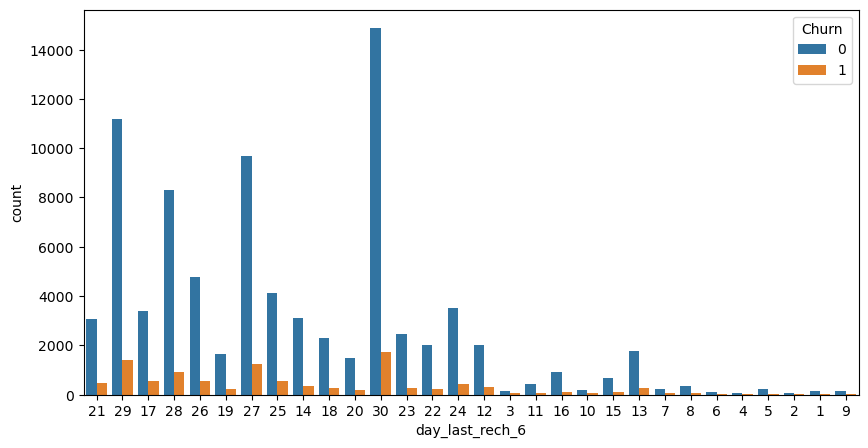

In [52]:
plt.figure(figsize=[10,5])
sns.countplot(data=churn_data, x="day_last_rech_6", hue="Churn")
plt.show()

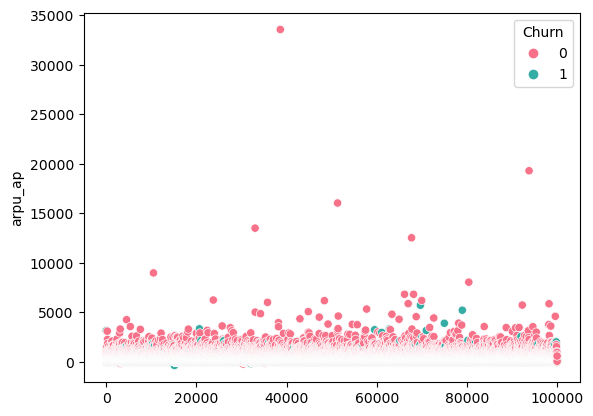

In [53]:
sns.scatterplot(data=churn_data, y="arpu_ap", x=churn_data.index, hue="Churn", palette="husl")
plt.show()

In [54]:
churn_data.groupby(by="Churn")["arpu_ap"].mean().round(2)

Churn
0    308.82
1    136.96
Name: arpu_ap, dtype: float64

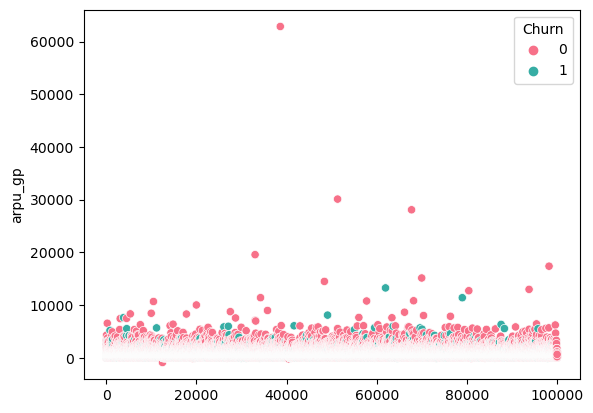

In [55]:
sns.scatterplot(data=churn_data, y="arpu_gp", x=churn_data.index, hue="Churn", palette="husl")
plt.show()

In [56]:
churn_data.groupby(by="Churn")["arpu_gp"].mean().round(2)

Churn
0    583.31
1    515.01
Name: arpu_gp, dtype: float64

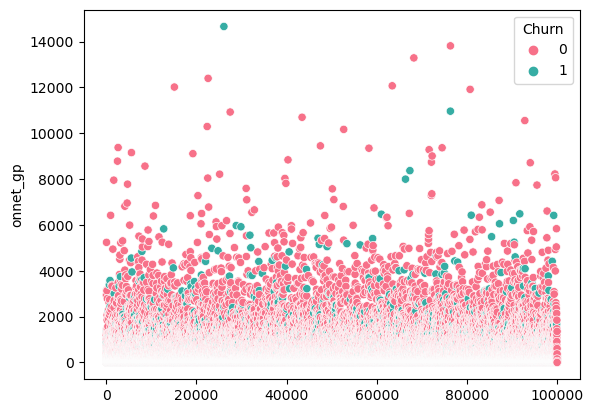

In [57]:
sns.scatterplot(data=churn_data, y="onnet_gp", x=churn_data.index, hue="Churn", palette="husl")
plt.show()

In [58]:
churn_data.groupby(by="Churn")["onnet_gp"].mean().round(2)

Churn
0    265.10
1    268.44
Name: onnet_gp, dtype: float64

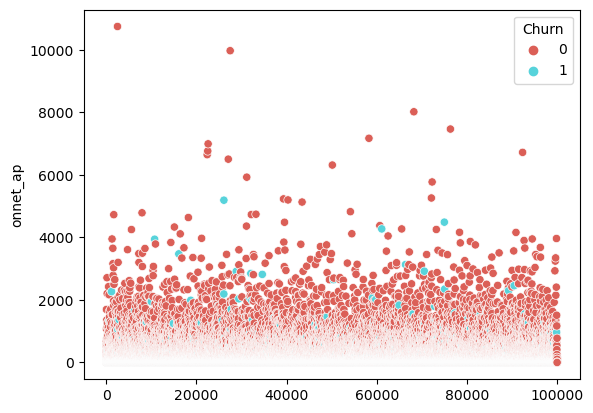

In [59]:
sns.scatterplot(data=churn_data, y="onnet_ap", x=churn_data.index, hue="Churn", palette="hls")
plt.show()

In [60]:
churn_data.groupby(by="Churn")["onnet_ap"].mean().round(2)

Churn
0    141.0
1     58.8
Name: onnet_ap, dtype: float64

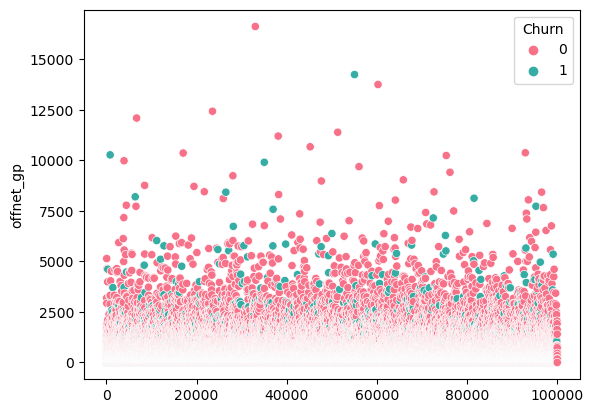

In [61]:
sns.scatterplot(data=churn_data, y="offnet_gp", x=churn_data.index, hue="Churn", palette="husl")
plt.show()

In [62]:
churn_data.groupby(by="Churn")["offnet_gp"].mean().round(2)

Churn
0    398.94
1    357.87
Name: offnet_gp, dtype: float64

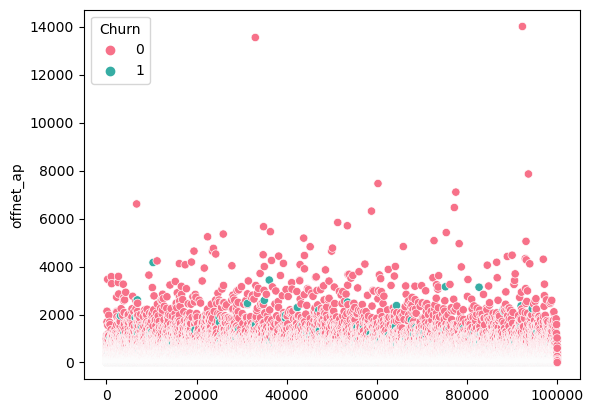

In [63]:
sns.scatterplot(data=churn_data, y="offnet_ap", x=churn_data.index, hue="Churn", palette="husl")
plt.show()

In [64]:
churn_data.groupby(by="Churn")["offnet_ap"].mean().round(2)

Churn
0    209.02
1     89.69
Name: offnet_ap, dtype: float64

In [65]:
churn_data[['loc_og_ap', 'std_og_ap', 'isd_og_ap', 'spl_og_ap', 'og_others_ap']].sum(axis=1)

0          0.00
1        312.43
2        285.44
3        352.19
4        208.16
          ...  
99991     88.78
99992    262.92
99994     58.70
99995     82.46
99997      0.00
Length: 94115, dtype: float64

In [66]:
churn_data["total_og_ap"]

0          0.00
1        312.44
2        285.46
3        352.21
4        208.16
          ...  
99991     88.79
99992    262.93
99994     58.71
99995     82.46
99997      0.00
Name: total_og_ap, Length: 94115, dtype: float64

In [67]:
churn_data[['loc_og_gp', 'std_og_gp', 
'isd_og_gp', 'spl_og_gp', 'og_others_gp']].sum(axis=1)

0        151.52
1        218.82
2        568.24
3        358.53
4        368.60
          ...  
99991    176.90
99992    385.49
99994     81.43
99995    217.22
99997      0.00
Length: 94115, dtype: float64

In [68]:
churn_data["total_og_gp"]

0          0.00
1        218.84
2        568.27
3        358.54
4        368.61
          ...  
99991    176.92
99992    385.51
99994     81.43
99995    217.23
99997      0.00
Name: total_og_gp, Length: 94115, dtype: float64

From the above 2 code blocks it is evident that the values of the columns `'total_og_ap', 'total_og_ap'` is exactly same as the sum of the data of the columns `['loc_og_ap', 'std_og_ap', 
'isd_og_ap', 'spl_og_ap', 'og_others_ap', 'loc_og_gp', 'std_og_gp', 
'isd_og_gp', 'spl_og_gp', 'og_others_gp']` hence dropping those columns.

In [69]:
churn_data.drop(labels=['loc_og_ap', 'std_og_ap', 
'isd_og_ap', 'spl_og_ap', 'og_others_ap', 'loc_og_gp', 'std_og_gp', 
'isd_og_gp', 'spl_og_gp', 'og_others_gp'], axis=1, inplace=True)

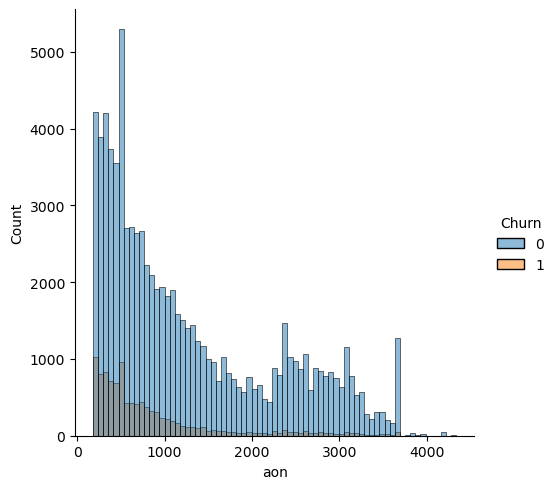

In [70]:
sns.displot(data=churn_data, x="aon", hue="Churn")
plt.show()

In [71]:
churn_data.groupby(by="Churn")["aon"].median().round(2)

Churn
0    938.0
1    567.0
Name: aon, dtype: float64

In [72]:
goodPhase_vbc = churn_data[['jun_vbc_3g']]+churn_data[['jun_vbc_3g']]
actionPhase_vbc = churn_data[['aug_vbc_3g']]

In [73]:
# Percentage decrease in Volume Base Cost between Good Phase and Action Phase
round((actionPhase_vbc.values.mean()/goodPhase_vbc.values.mean())*100, 2)

57.95

In [74]:
churn_data[['last_day_rch_amt_gp', 'last_day_rch_amt_ap']].mean()

last_day_rch_amt_gp    123.432747
last_day_rch_amt_ap     64.821814
dtype: float64

In [75]:
churn_data[['monthly_2g_gp', 'sachet_2g_gp', 'monthly_3g_gp', 'sachet_3g_gp']].max()

monthly_2g_gp     9
sachet_2g_gp     76
monthly_3g_gp    23
sachet_3g_gp     54
dtype: int64

In [76]:
churn_data[['monthly_2g_ap', 'sachet_2g_ap', 'monthly_3g_ap', 'sachet_3g_ap']].max()

monthly_2g_ap     5
sachet_2g_ap     44
monthly_3g_ap    16
sachet_3g_ap     41
dtype: int64

### Identifying HIGH VALUE CUSTOMERS

**`Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).`**

In [77]:
high_val_cus.columns

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_amt_6',
       'total_rech_amt_7'],
      dtype='object')

In [78]:
churn = pd.concat([churn_data, high_val_cus], axis=1)

In [79]:
drop_index = churn[(churn.loc[:,'total_rech_num_gp']>0) & (churn['total_rech_amt_gp']==0)][['total_rech_num_ap','total_rech_amt_ap']].index.tolist()

In [80]:
churn_data_copy = churn.drop(index=drop_index, axis=0)

In [81]:
# Perfomring integer division to get the floor values of the mean values.
high_val_mean = churn_data_copy.loc[:, ['total_rech_amt_6', 'total_rech_amt_7']].mean()*0.7 // 1

In [82]:
high_val_mean.loc[['total_rech_amt_6', 'total_rech_amt_7']]

total_rech_amt_6    239.0
total_rech_amt_7    240.0
dtype: float64

In [83]:
high_value = churn_data_copy[(churn_data_copy["total_rech_amt_6"]>high_val_mean.loc["total_rech_amt_6"]) & (churn_data_copy["total_rech_amt_7"]>high_val_mean.loc["total_rech_amt_7"])]
high_value.drop(labels=['total_rech_num_6', 'total_rech_num_7', 'total_rech_amt_6', 'total_rech_amt_7'], axis=1, inplace=True)

In [84]:
plt.figure(figsize=[100,100])
sns.heatmap(high_value.corr(), annot=True, cmap="YlOrBr")
plt.savefig("correlation.png")
plt.show()

## Modeling

### Train Test Split

In [85]:
high_value["Churn"].value_counts(normalize=True)*100

0    92.362684
1     7.637316
Name: Churn, dtype: float64

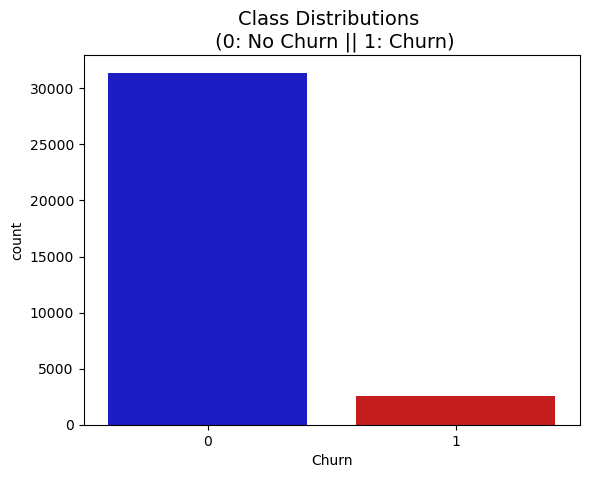

In [86]:
sns.countplot(data=high_value, x="Churn", palette=["#0101DF", "#DF0101"])
plt.title('Class Distributions \n (0: No Churn || 1: Churn)', fontsize=14)
plt.show()

In [87]:
high_value.columns.values

array(['arpu_ap', 'onnet_ap', 'offnet_ap', 'roam_ic_ap', 'roam_og_ap',
       'loc_og_t2t_ap', 'loc_og_t2m_ap', 'loc_og_t2f_ap', 'loc_og_t2c_ap',
       'std_og_t2t_ap', 'std_og_t2m_ap', 'std_og_t2f_ap', 'total_og_ap',
       'loc_ic_t2t_ap', 'loc_ic_t2m_ap', 'loc_ic_t2f_ap', 'loc_ic_ap',
       'std_ic_t2t_ap', 'std_ic_t2m_ap', 'std_ic_t2f_ap', 'std_ic_ap',
       'total_ic_ap', 'spl_ic_ap', 'isd_ic_ap', 'ic_others_ap',
       'total_rech_num_ap', 'total_rech_amt_ap', 'max_rech_amt_ap',
       'last_day_rch_amt_ap', 'vol_2g_mb_ap', 'vol_3g_mb_ap',
       'monthly_2g_ap', 'sachet_2g_ap', 'monthly_3g_ap', 'sachet_3g_ap',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g',
       'Churn', 'arpu_gp', 'onnet_gp', 'offnet_gp', 'roam_ic_gp',
       'roam_og_gp', 'loc_og_t2t_gp', 'loc_og_t2m_gp', 'loc_og_t2f_gp',
       'loc_og_t2c_gp', 'std_og_t2t_gp', 'std_og_t2m_gp', 'std_og_t2f_gp',
       'total_og_gp', 'loc_ic_t2t_gp', 'loc_ic_t2m_gp', 'loc_ic_t2f_gp',
       'loc_ic_g

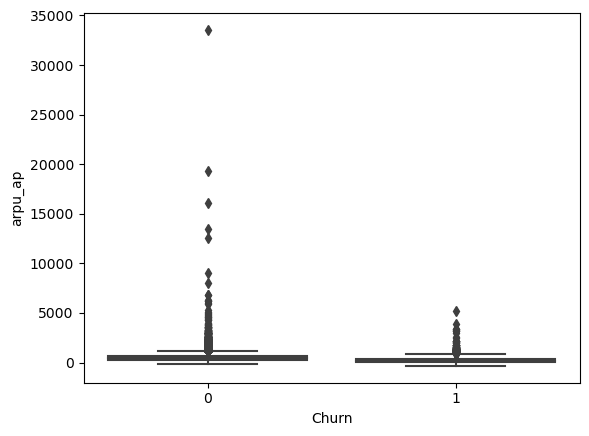

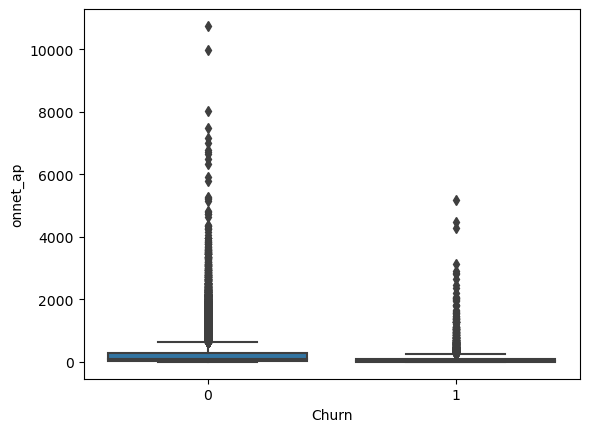

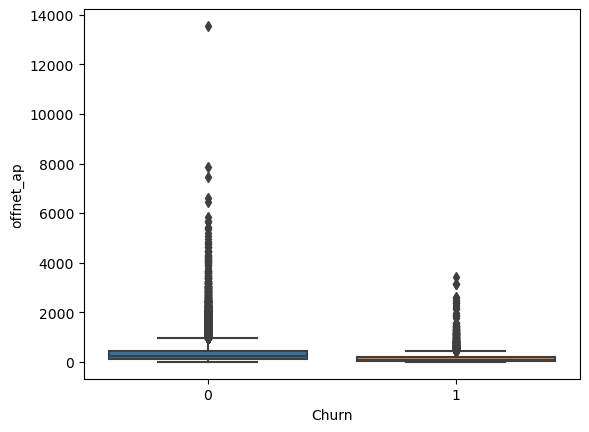

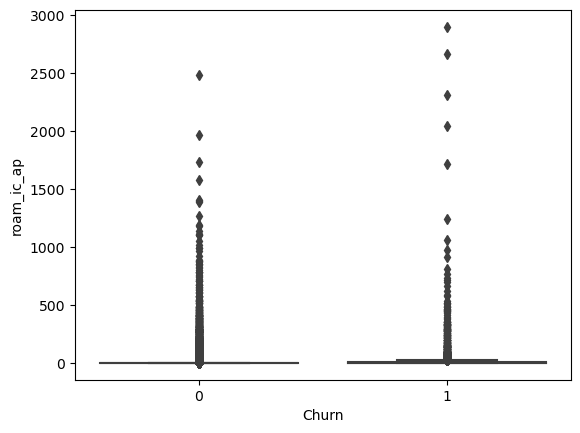

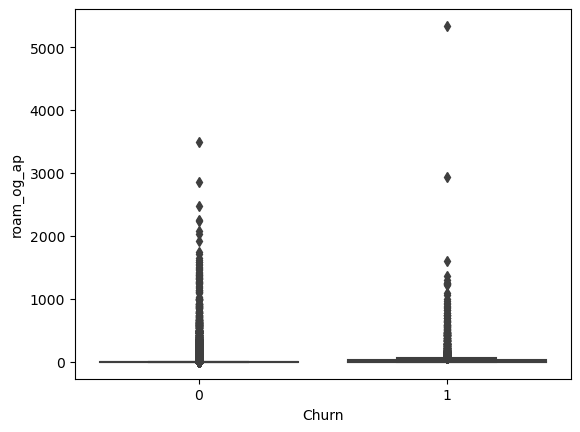

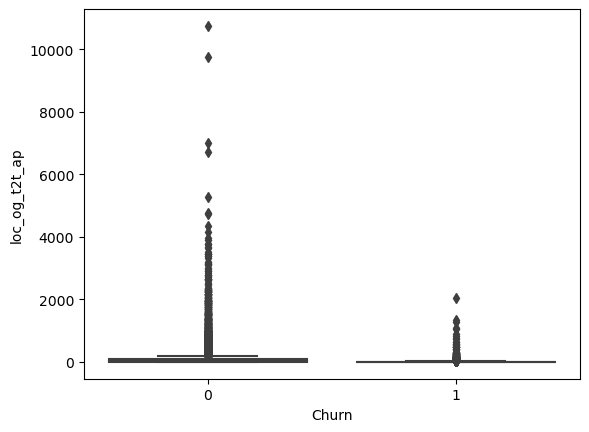

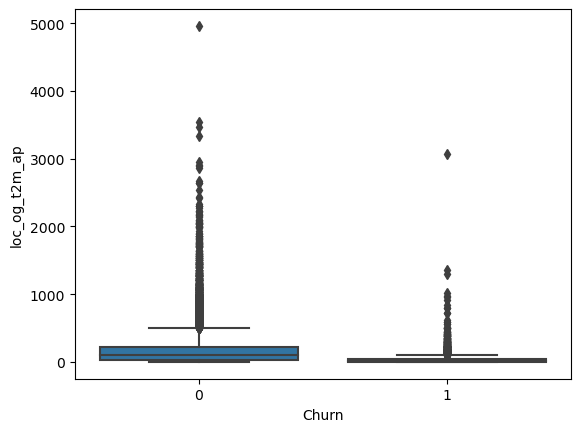

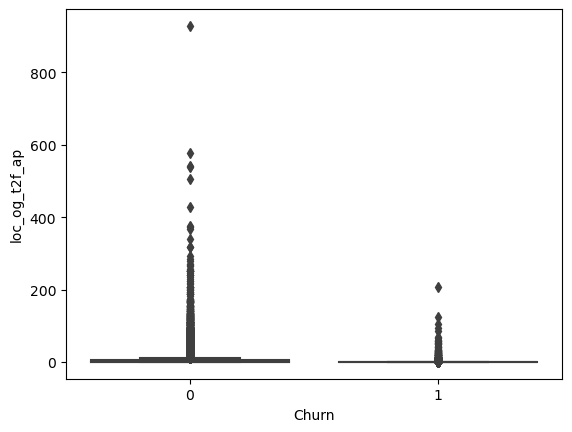

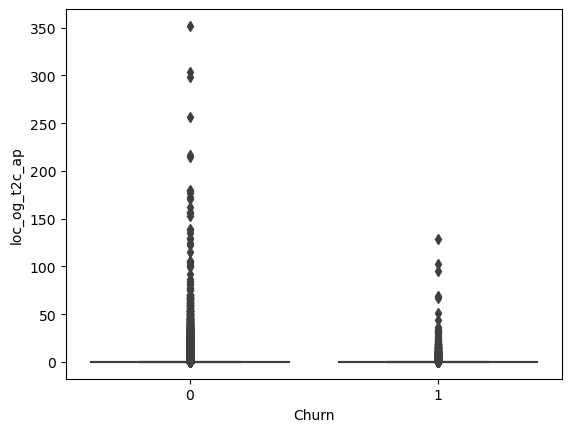

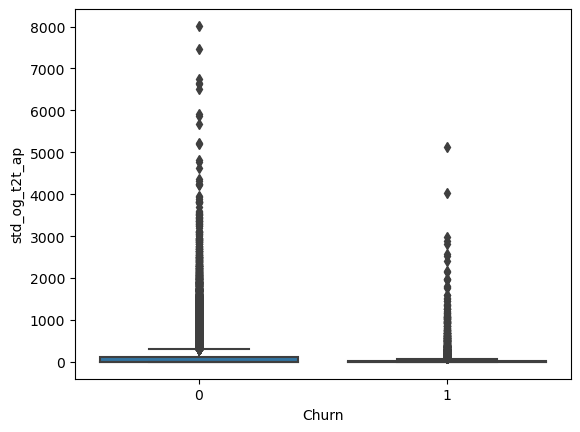

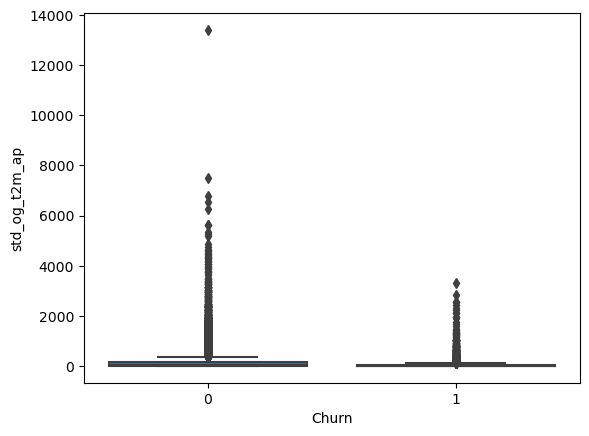

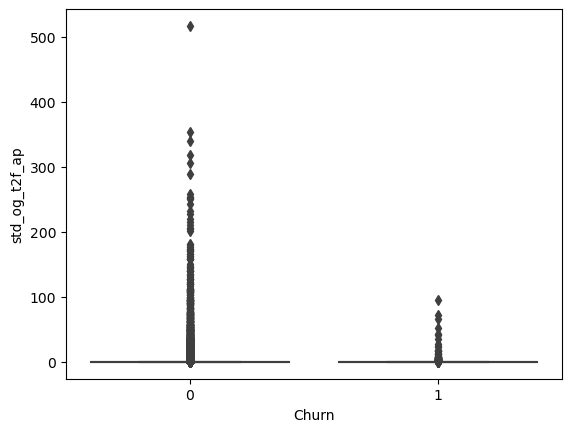

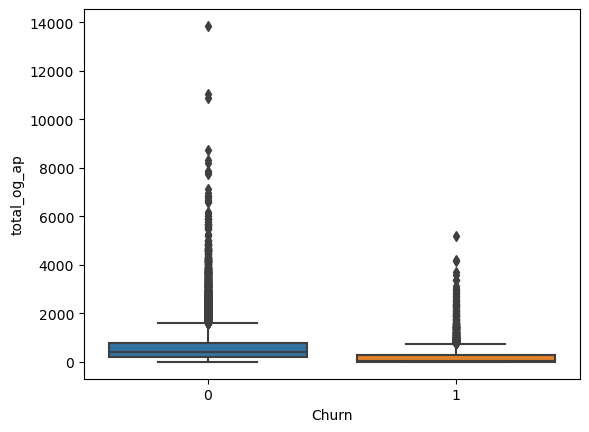

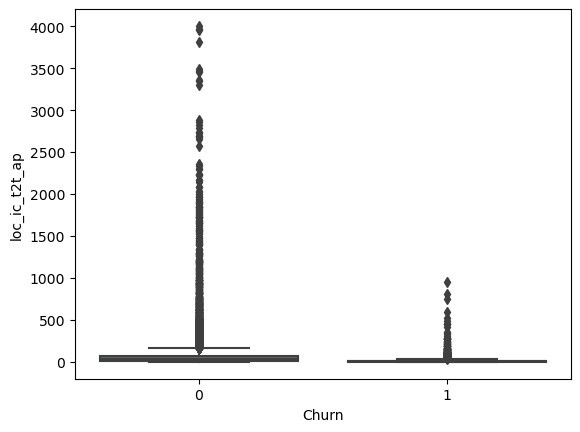

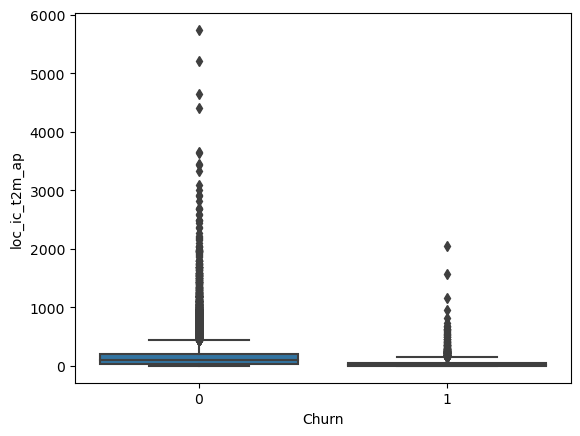

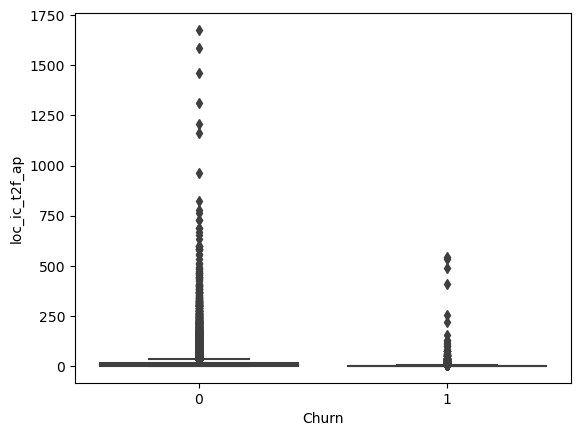

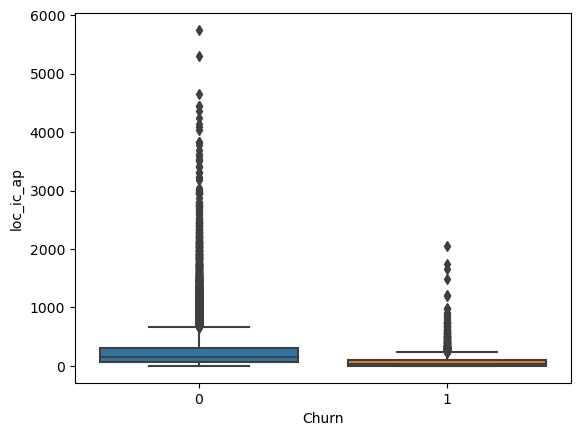

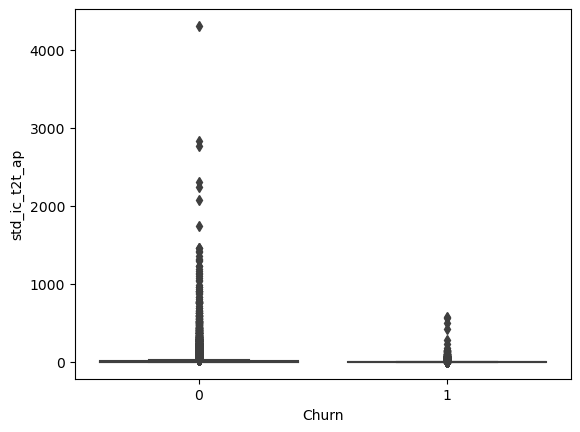

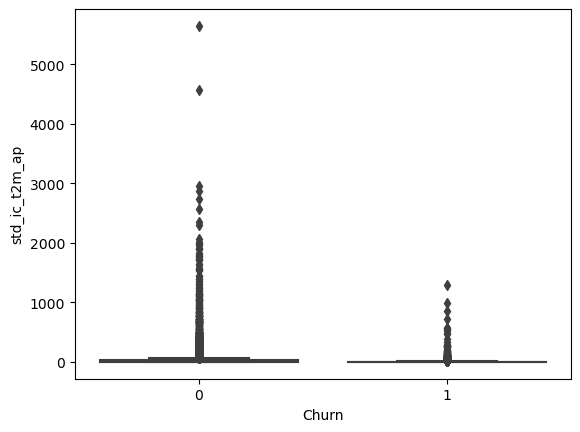

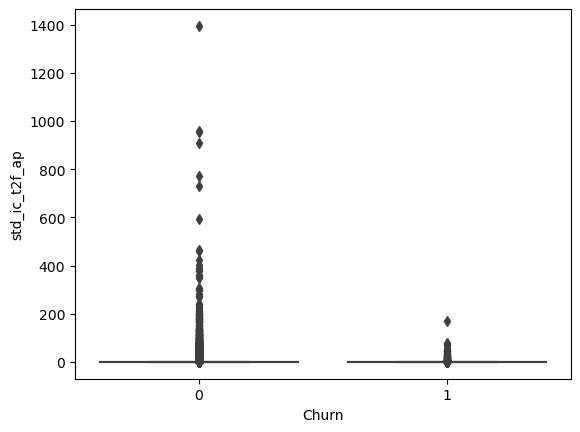

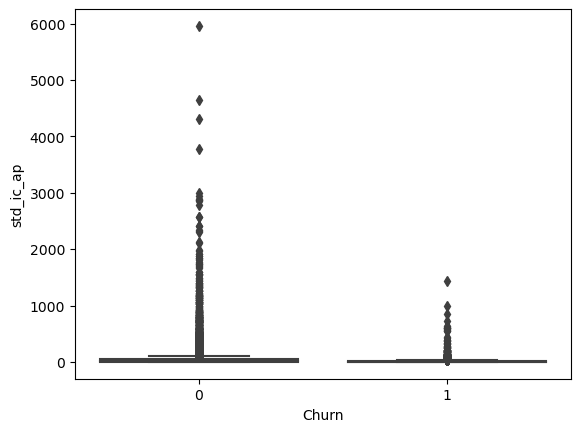

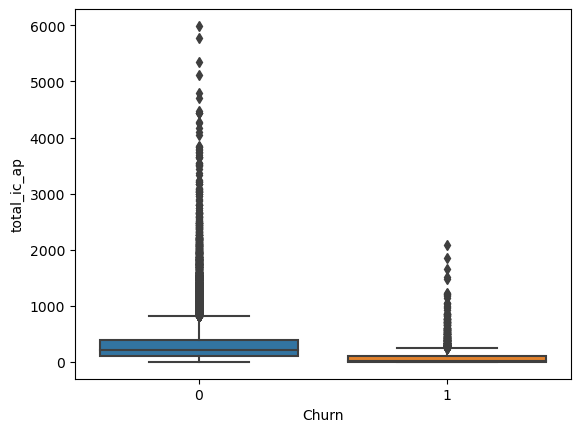

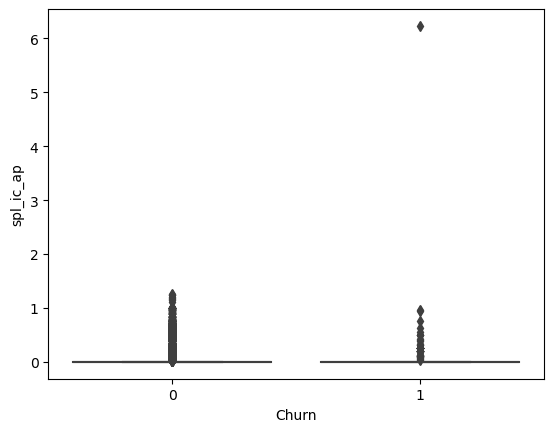

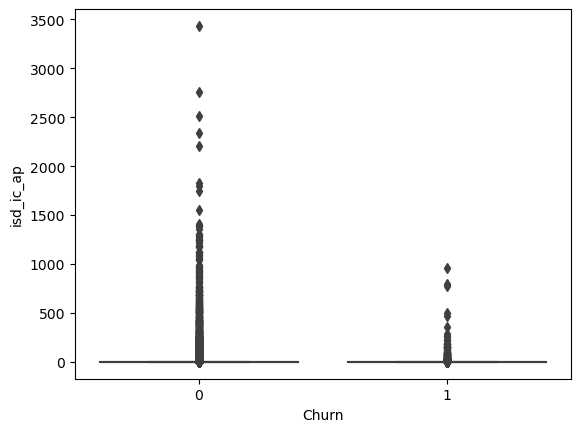

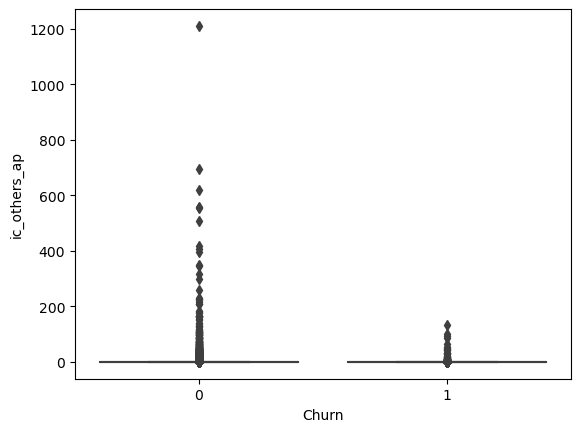

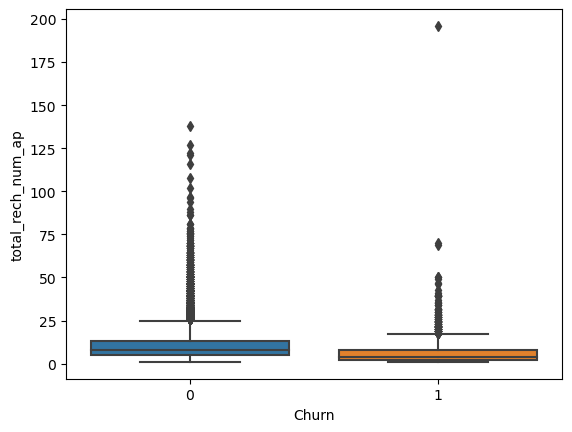

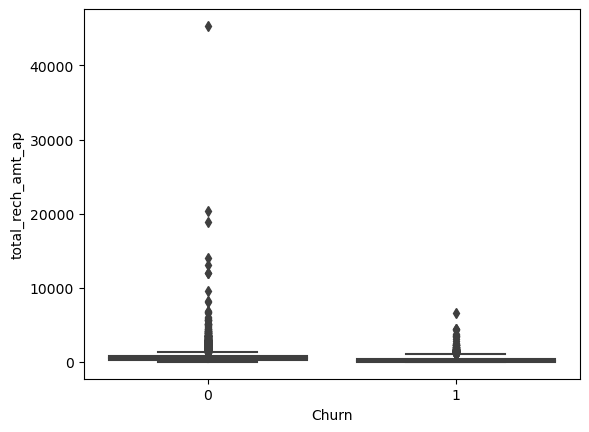

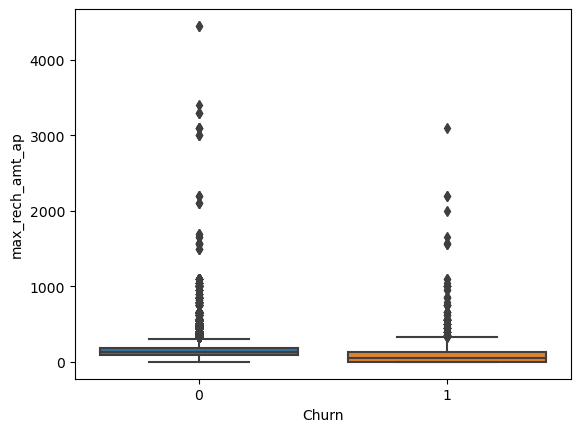

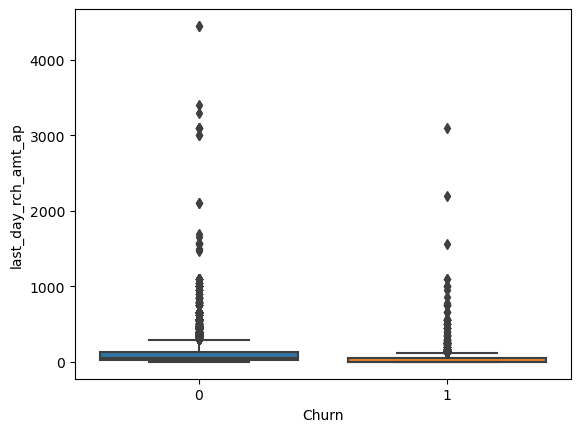

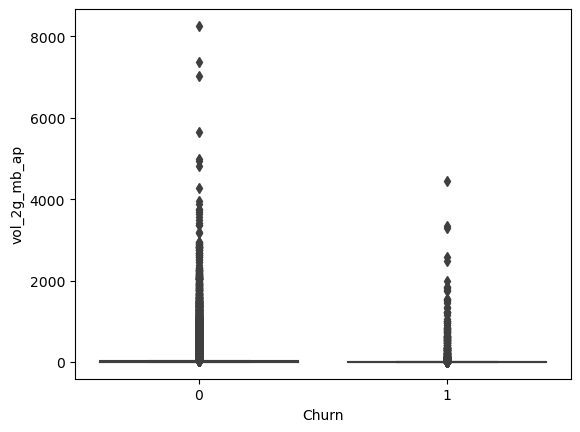

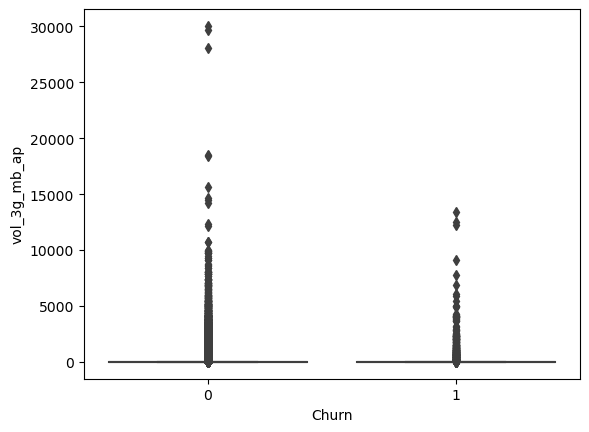

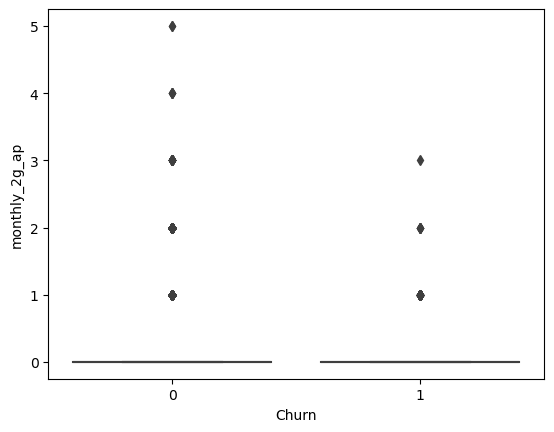

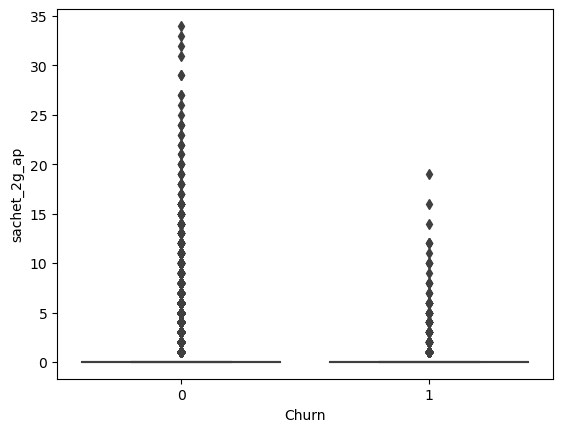

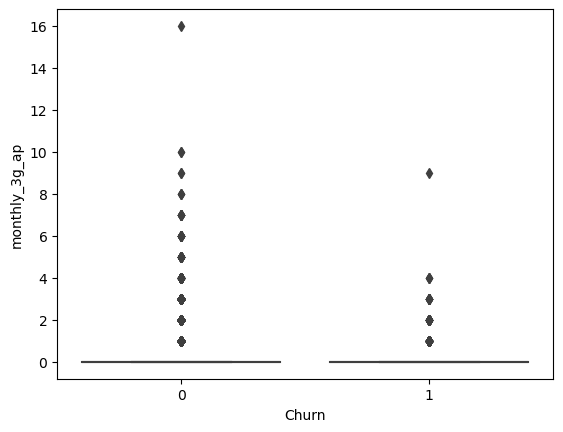

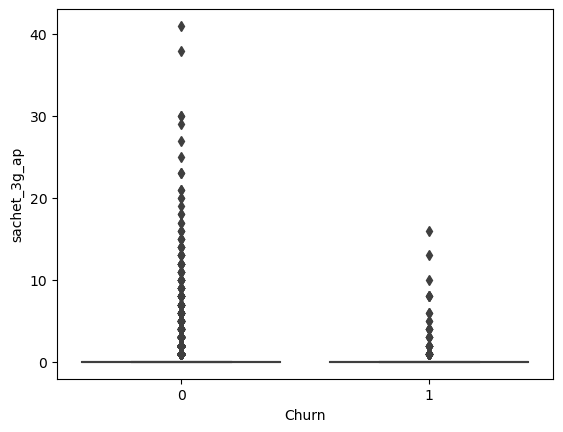

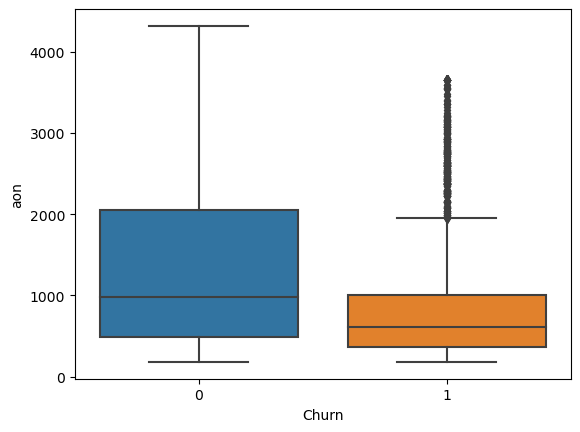

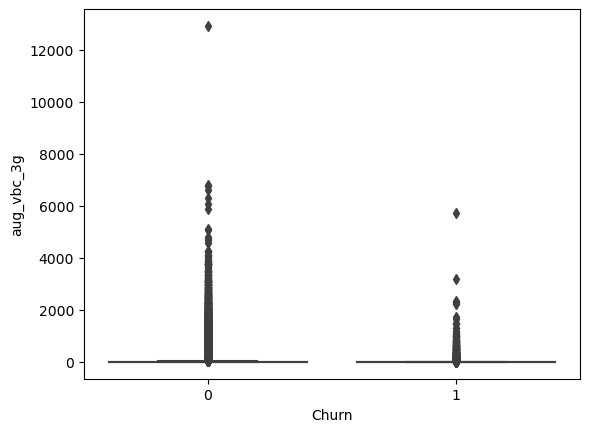

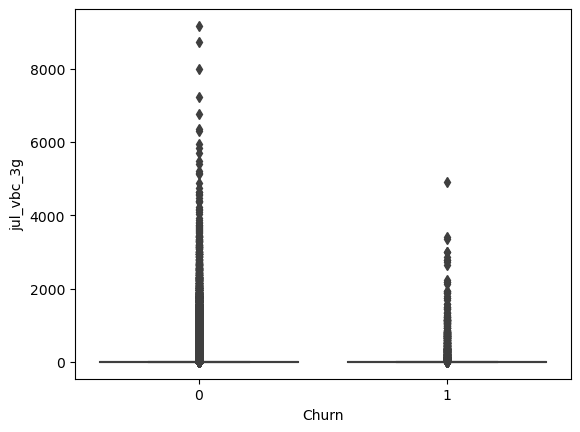

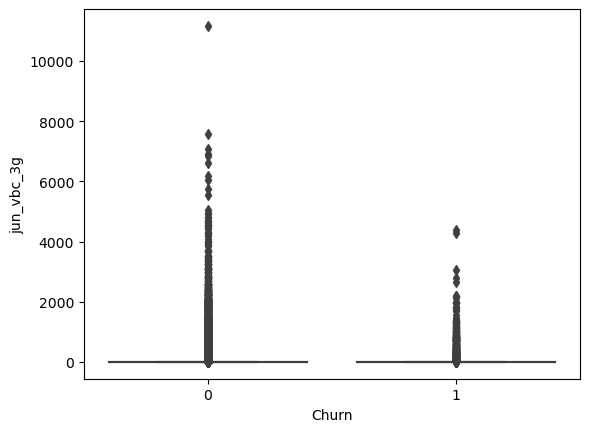

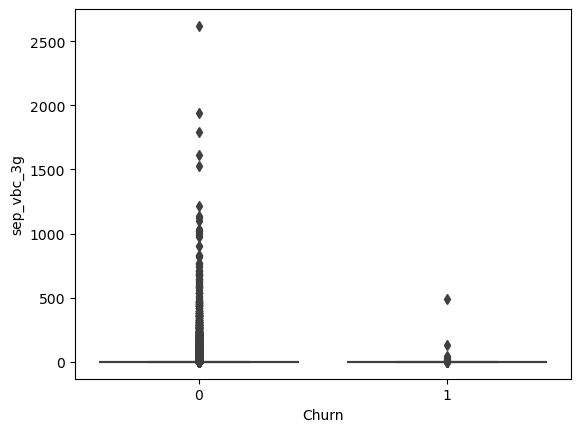

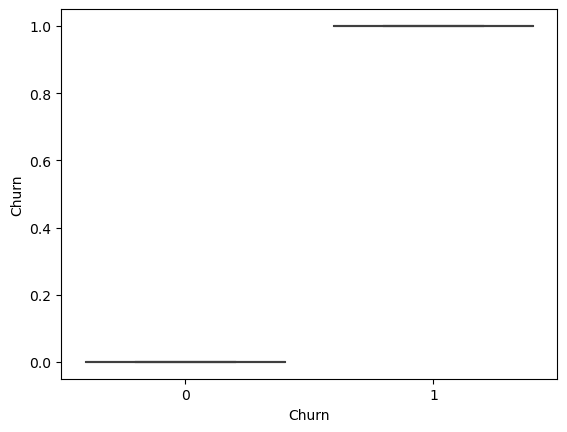

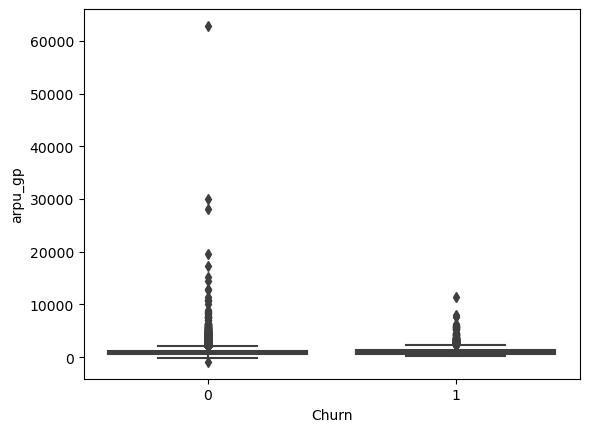

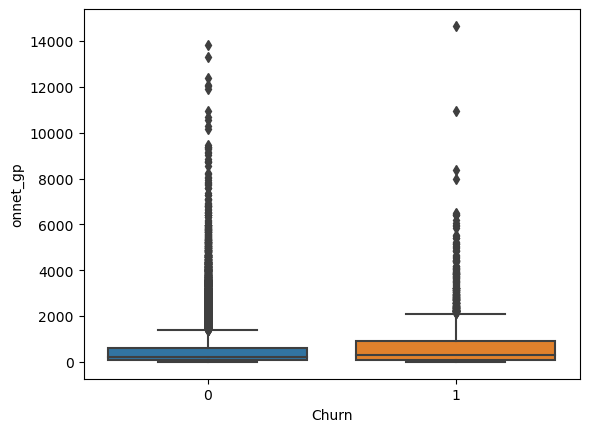

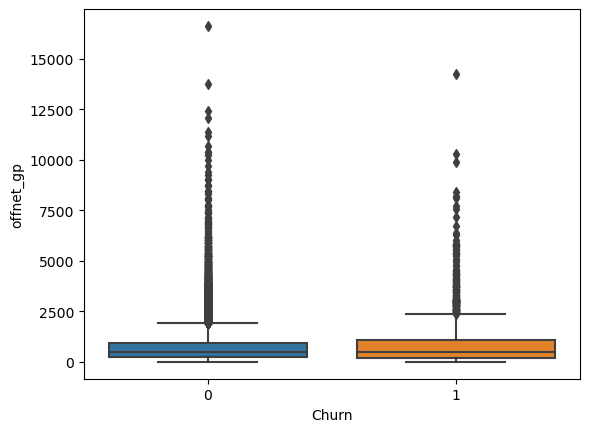

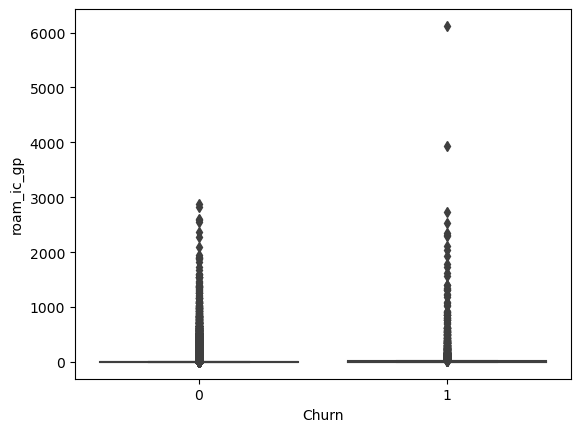

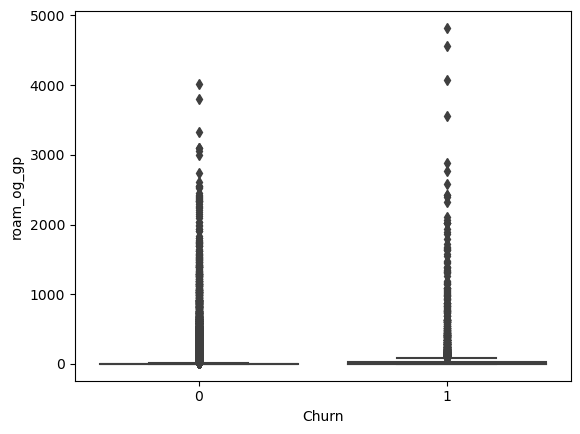

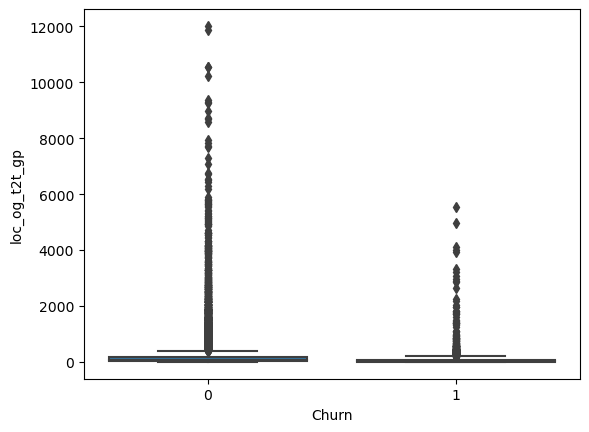

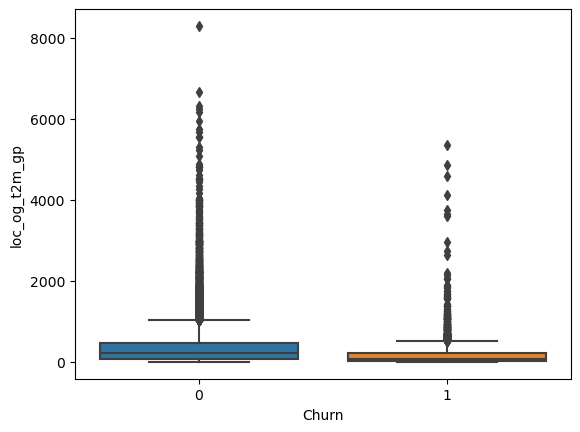

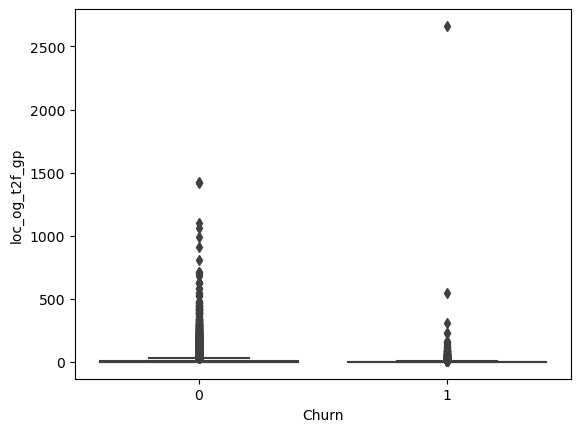

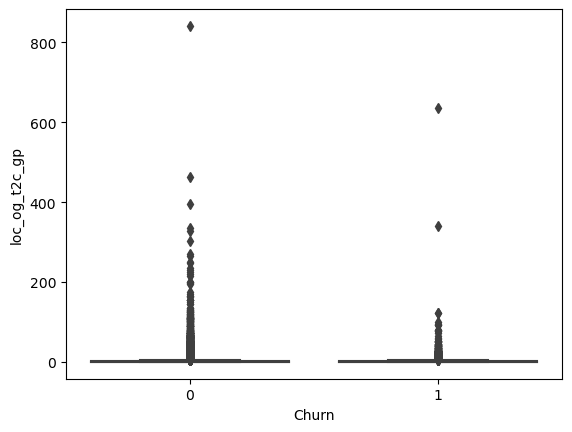

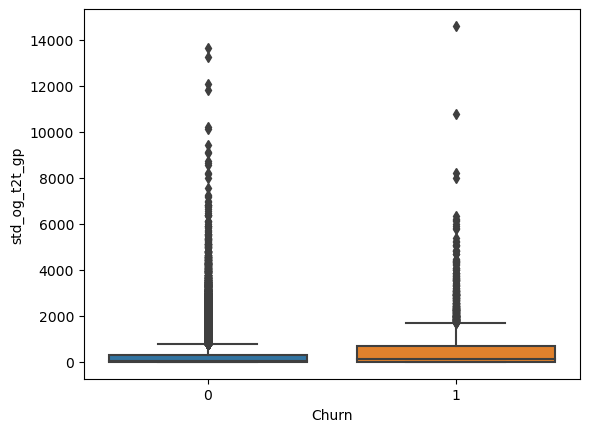

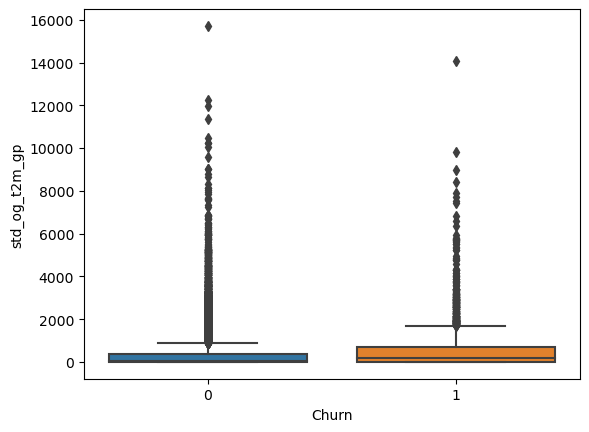

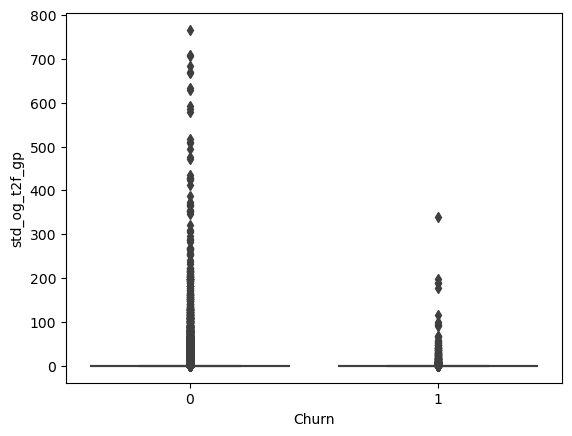

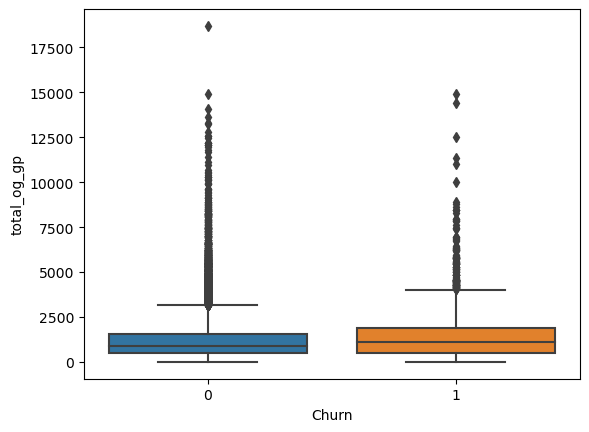

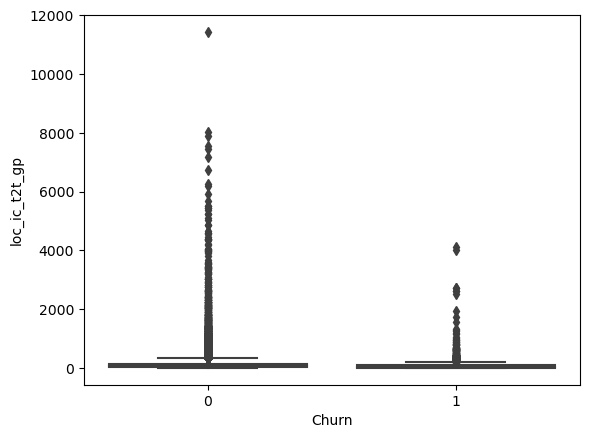

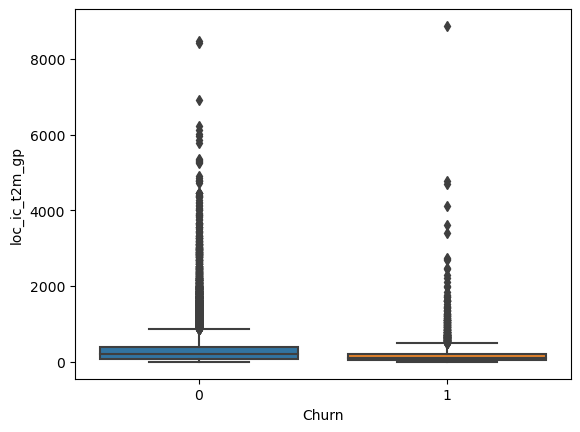

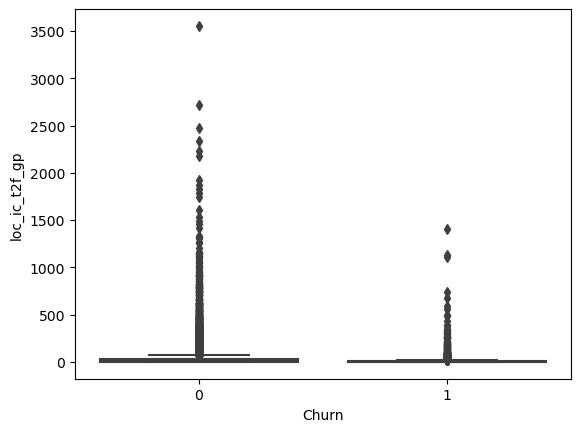

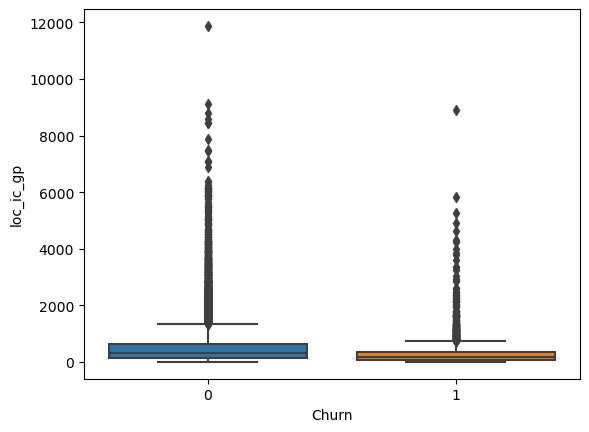

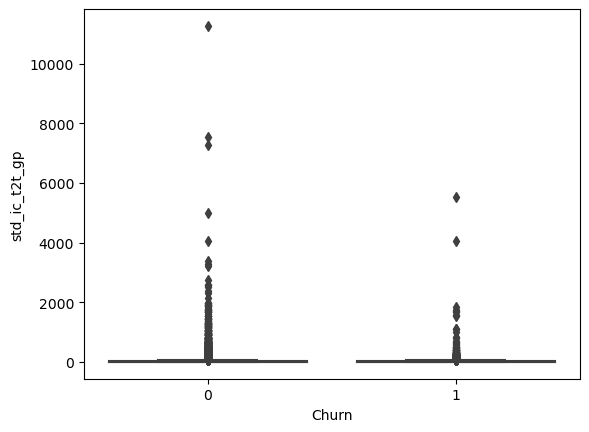

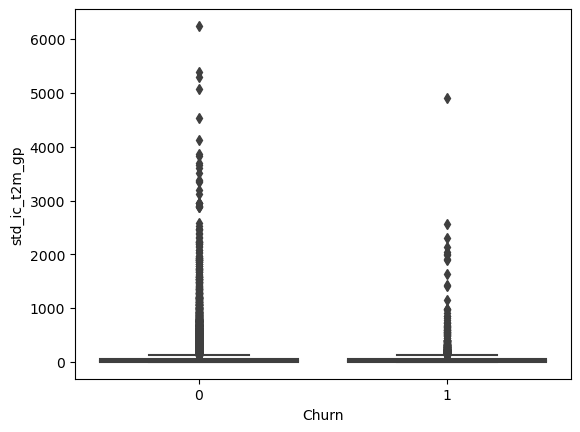

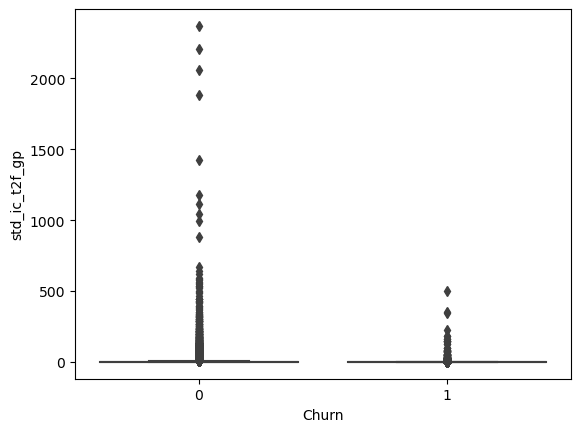

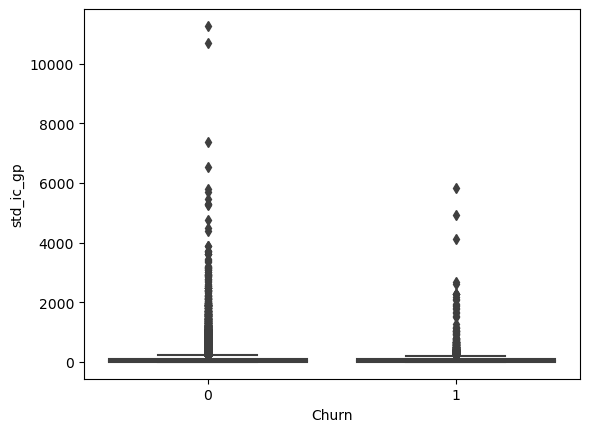

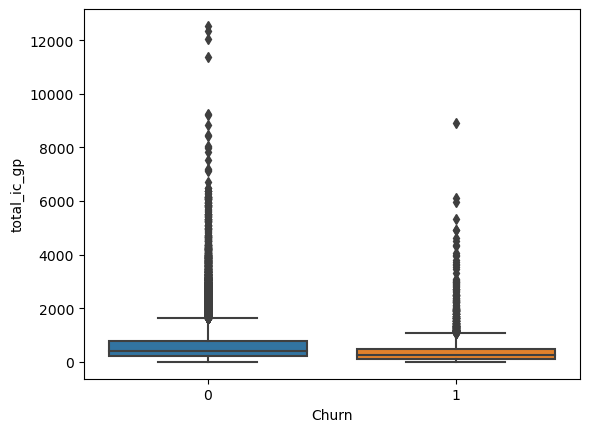

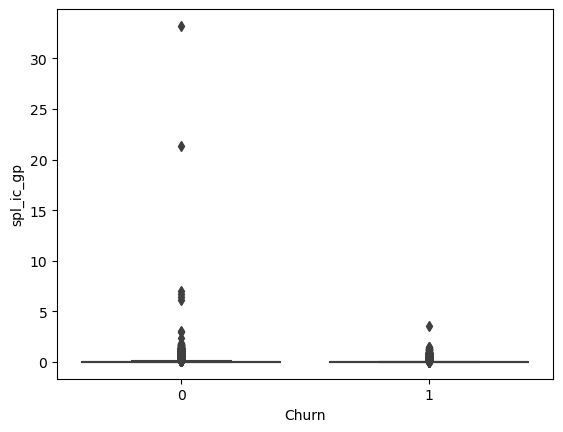

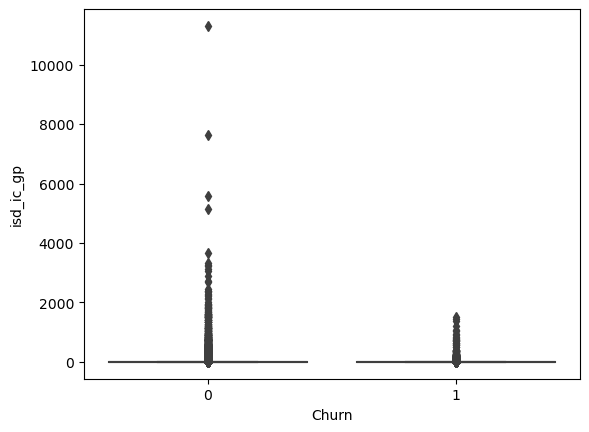

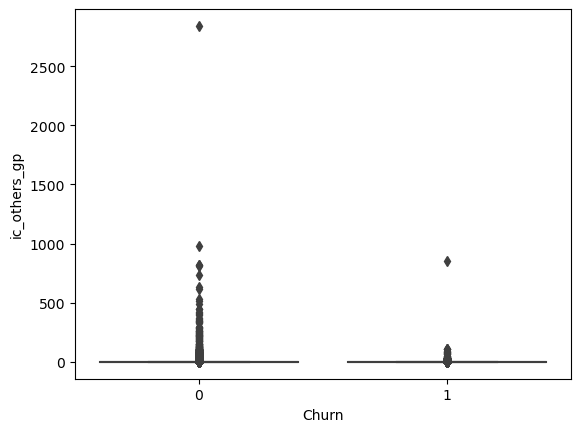

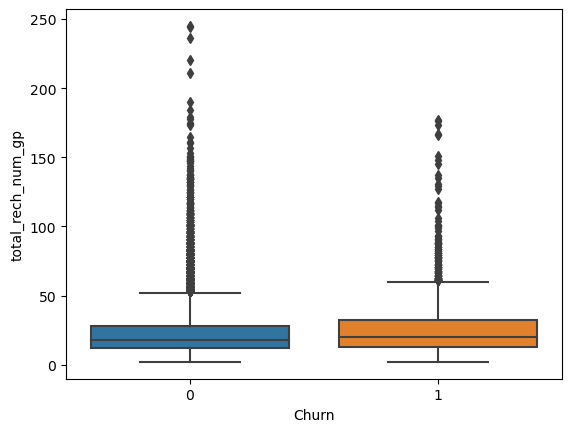

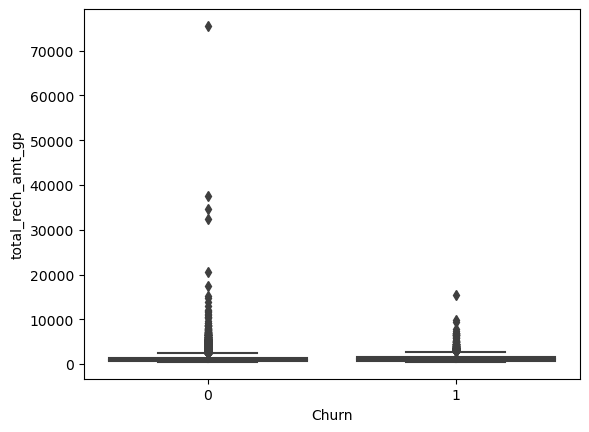

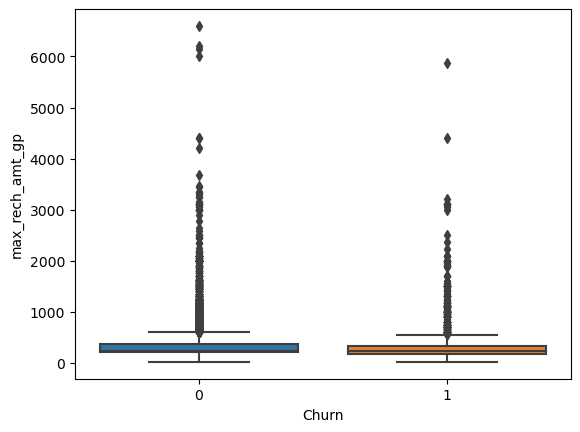

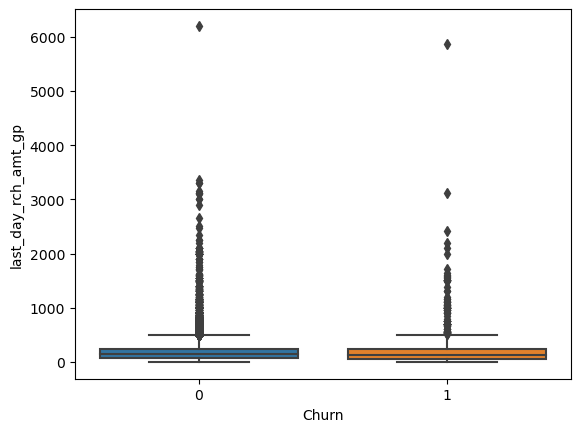

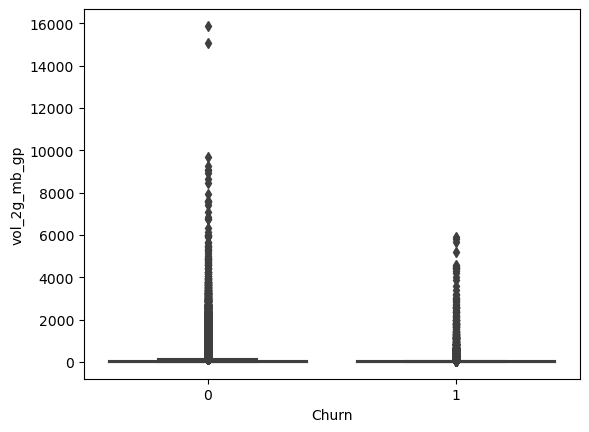

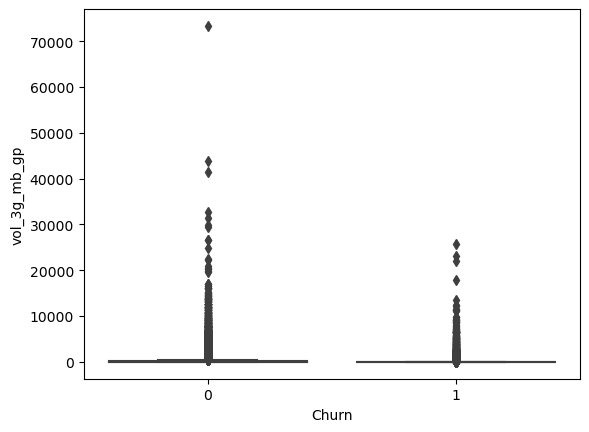

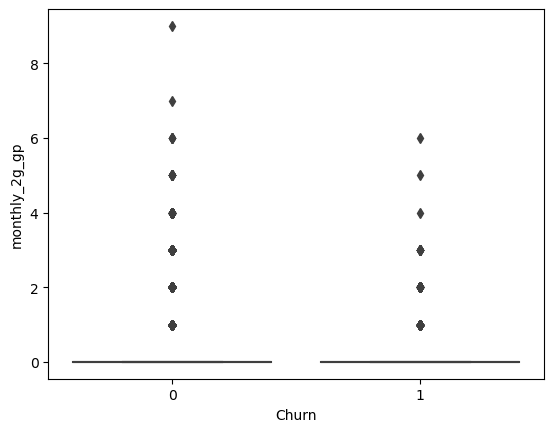

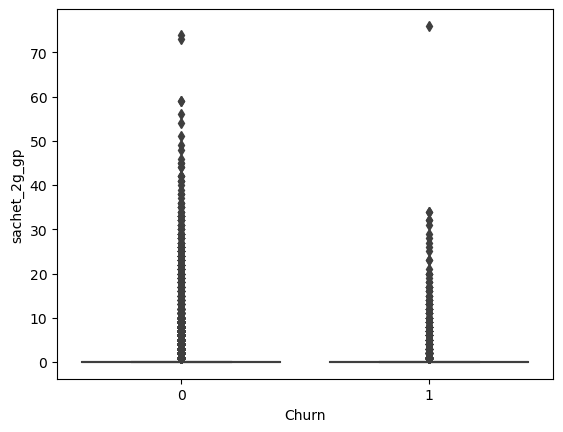

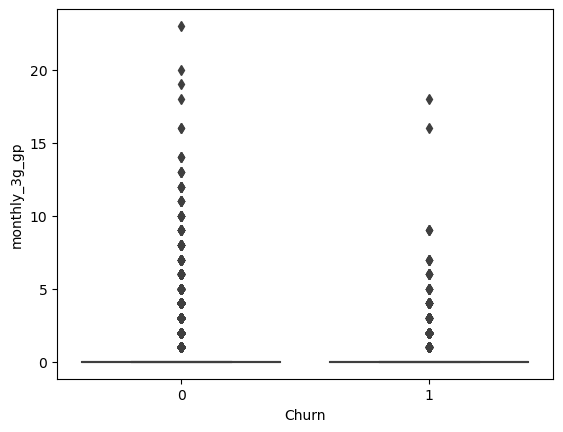

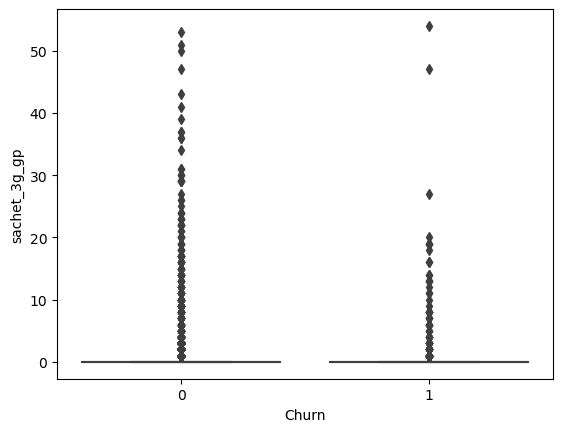

In [88]:
for i in high_value.columns.values:
    if i.__contains__("day_last"):
        continue
    sns.boxplot(data=high_value.select_dtypes(exclude="object"), y=i, x="Churn")
    plt.show()

There are huge number of outliers in the data, instead of removing the outliers, which would lead to loss of data. We can transform the data, we can use 4th root of the values

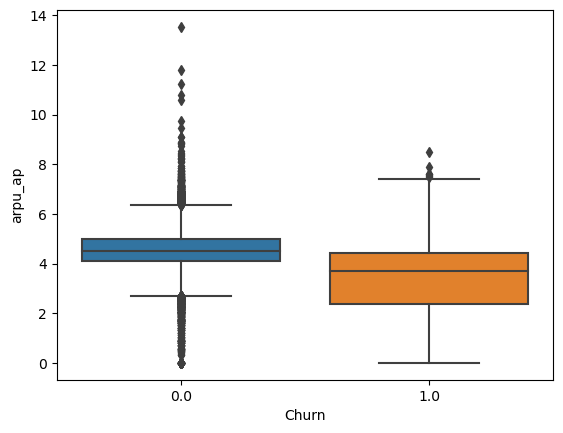

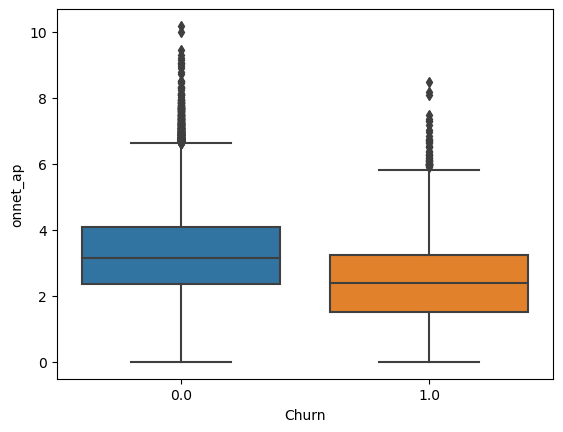

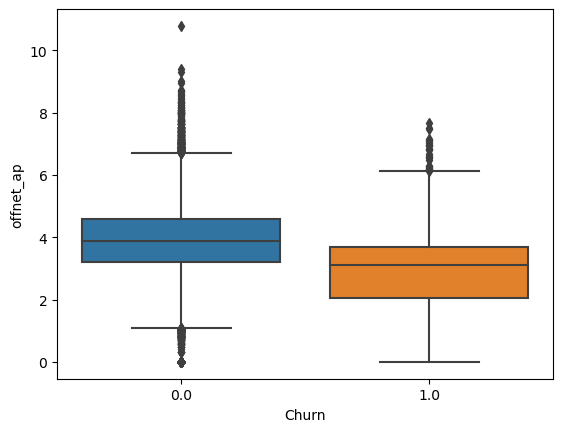

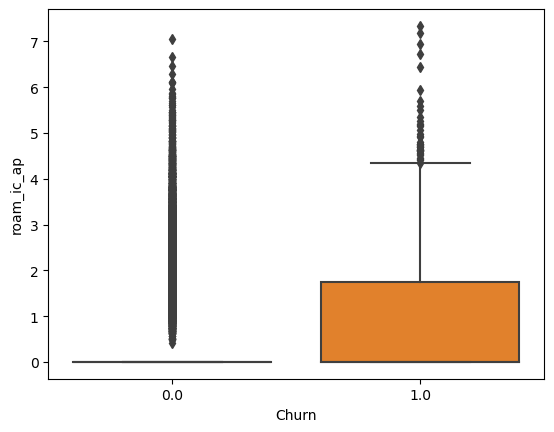

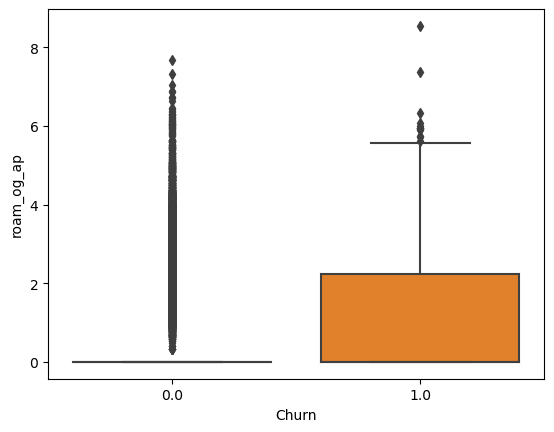

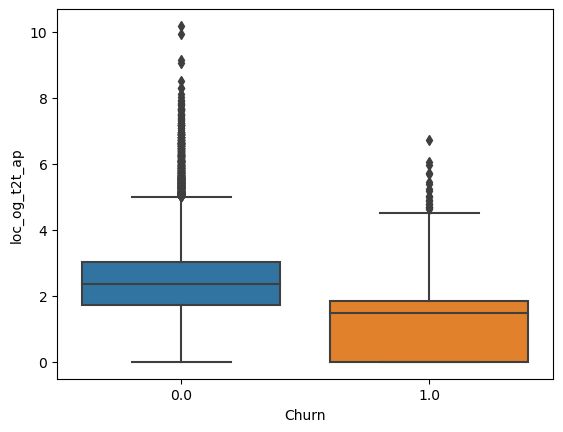

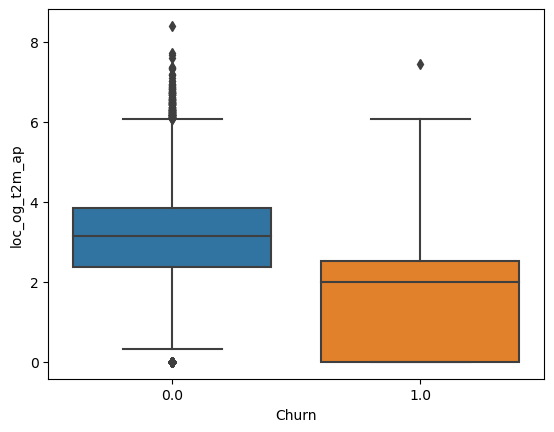

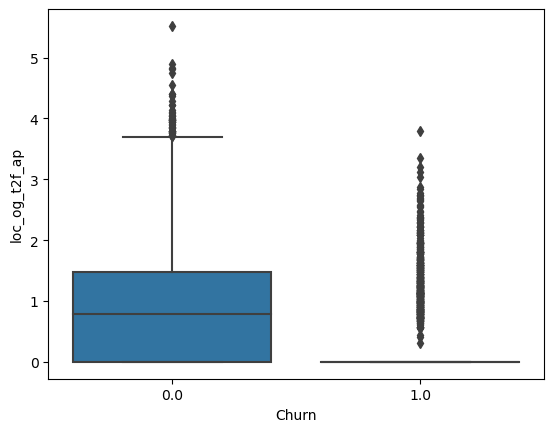

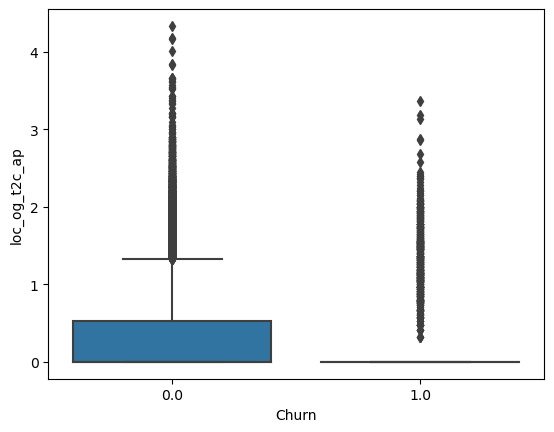

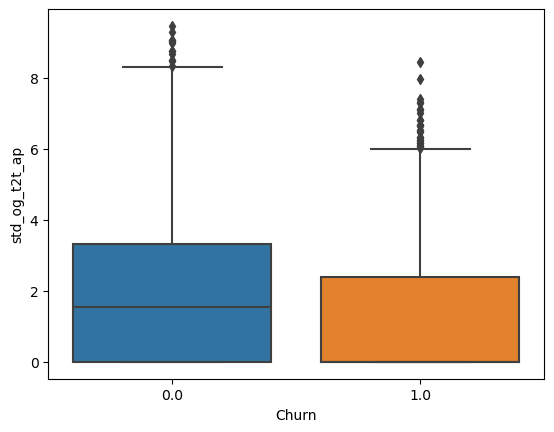

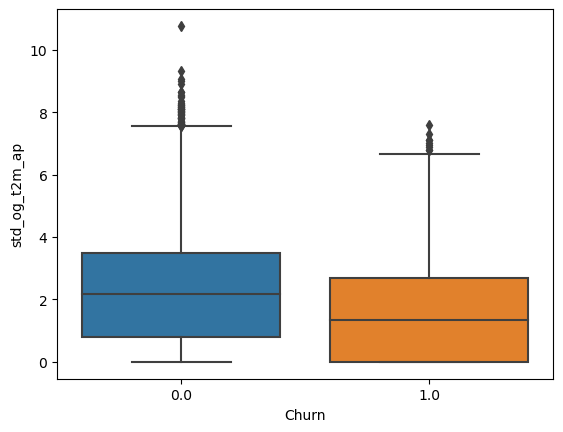

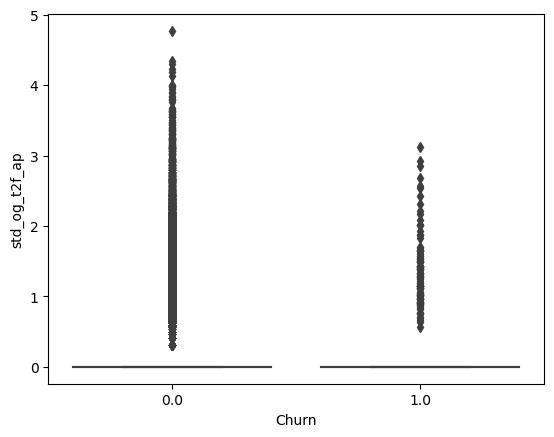

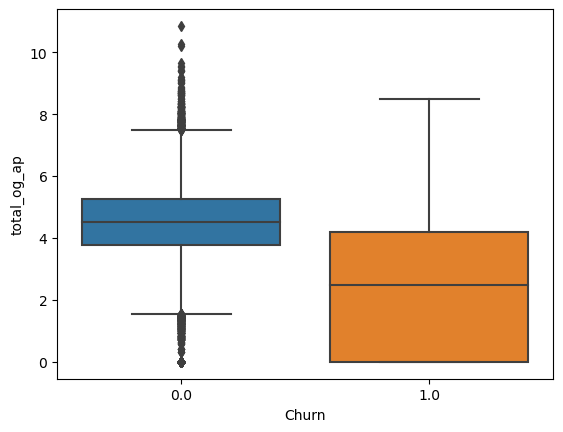

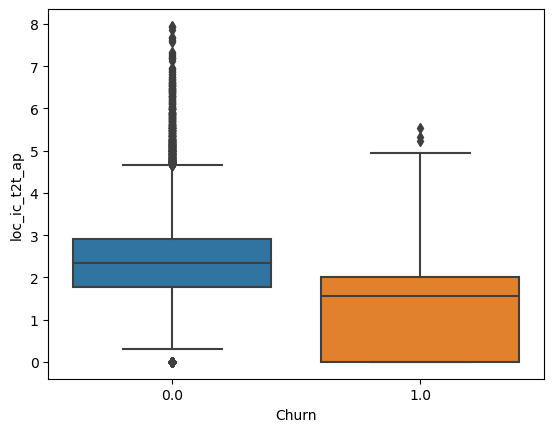

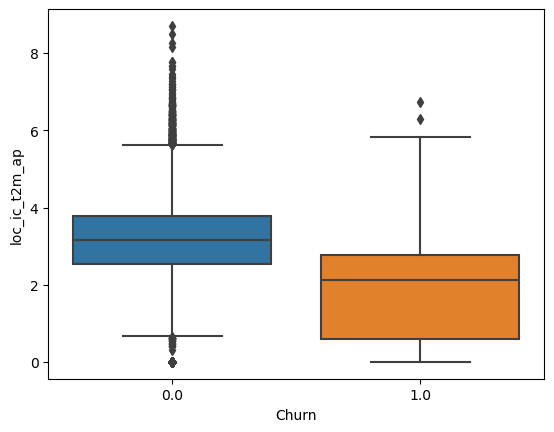

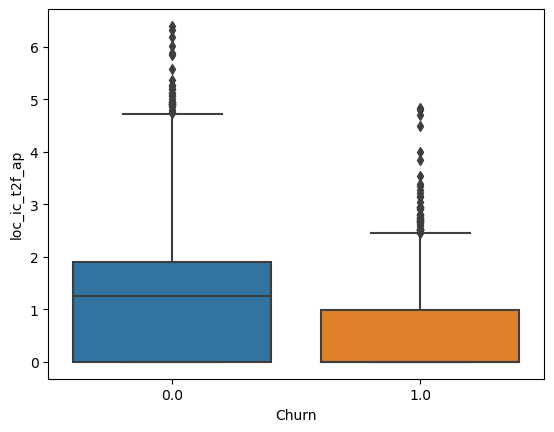

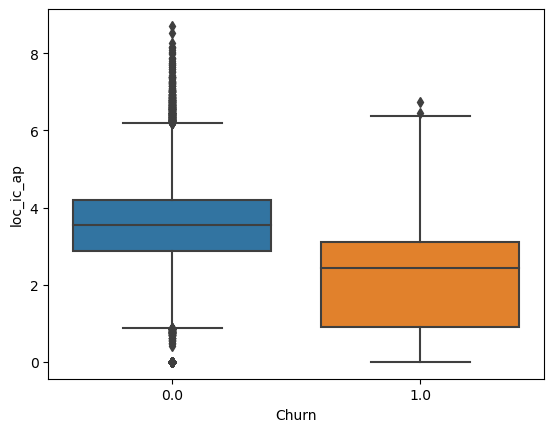

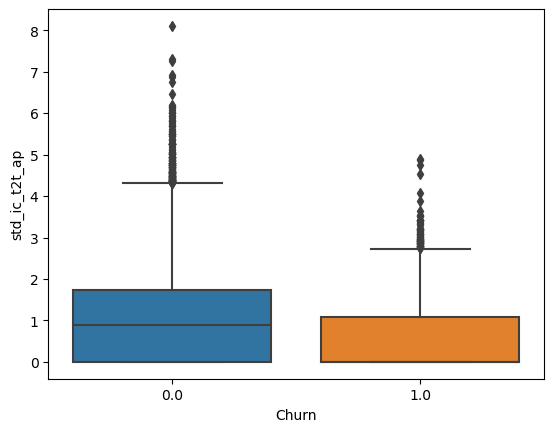

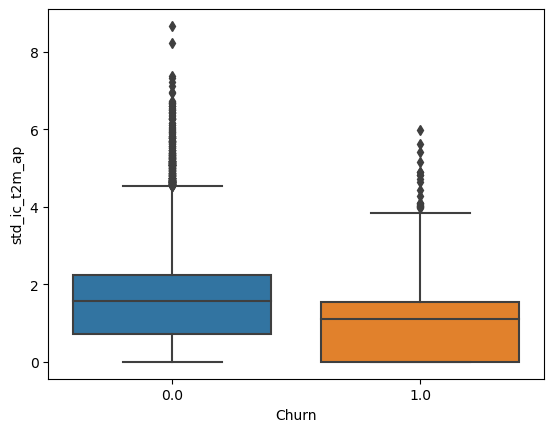

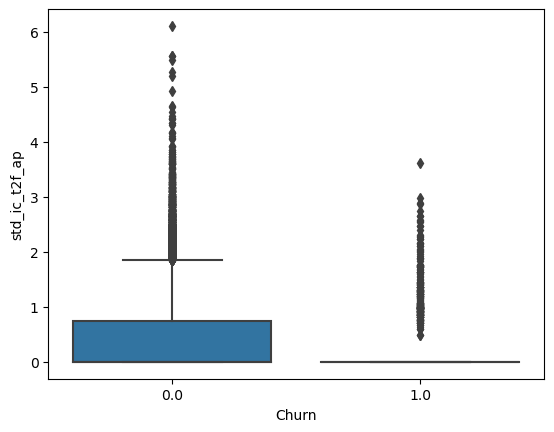

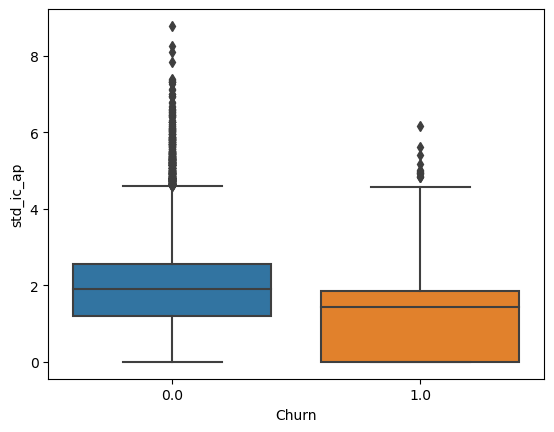

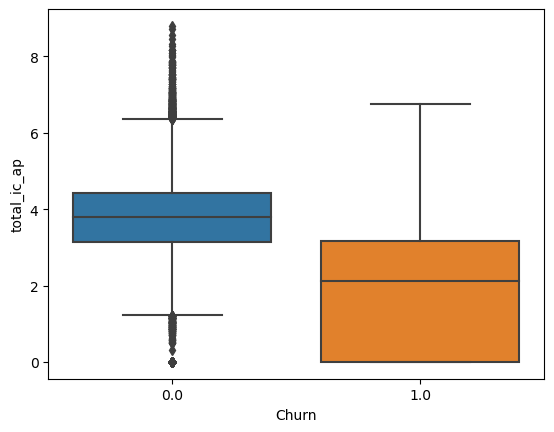

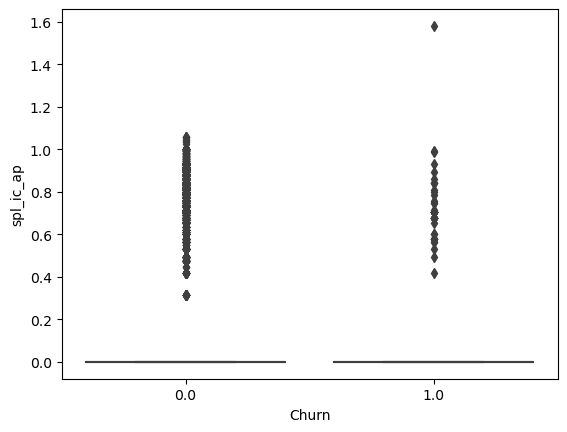

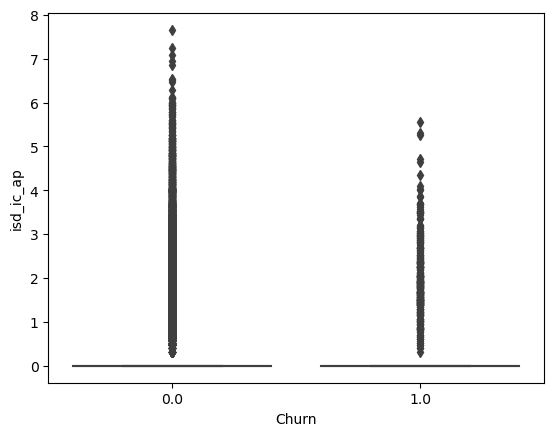

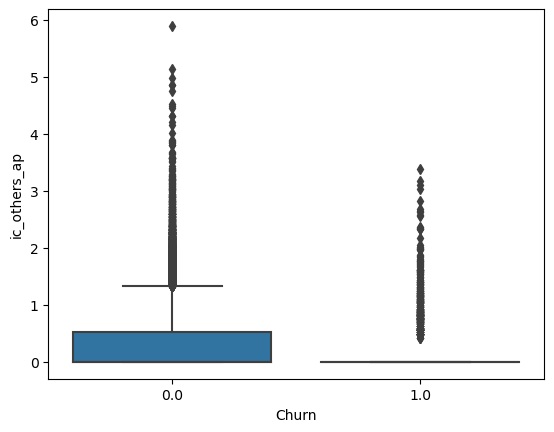

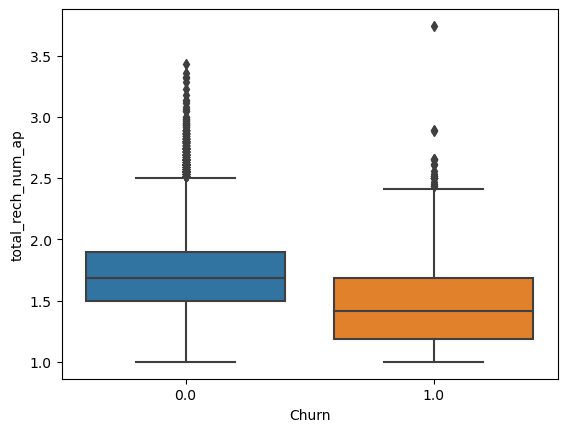

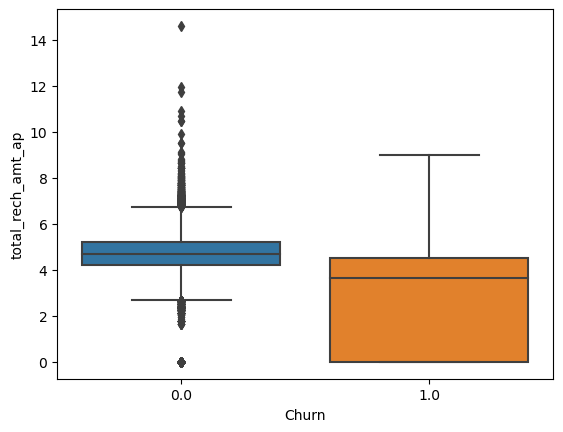

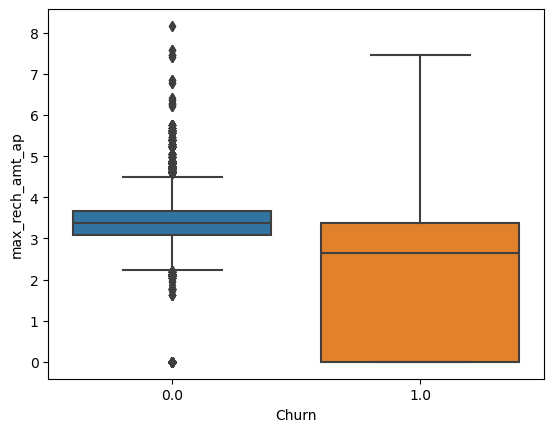

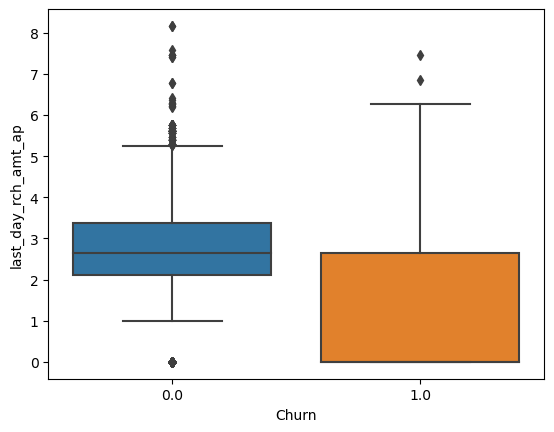

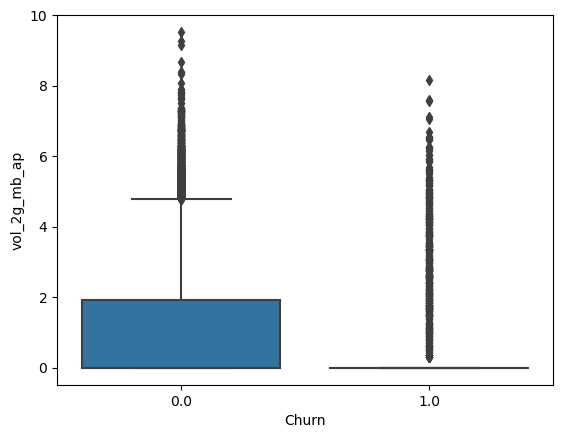

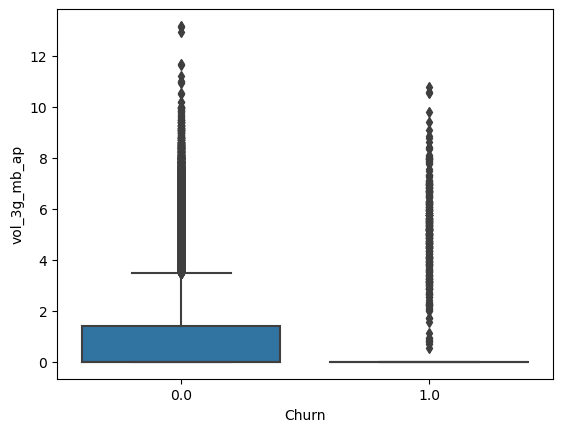

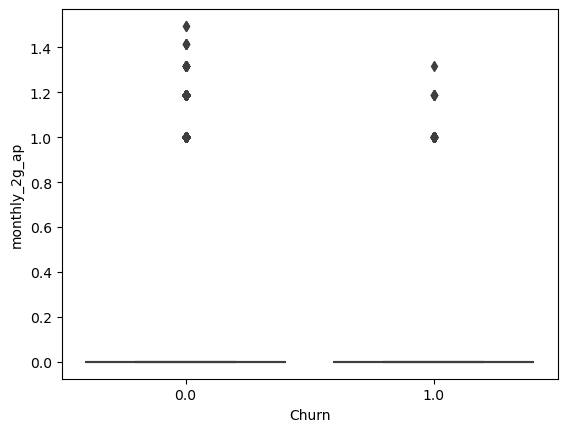

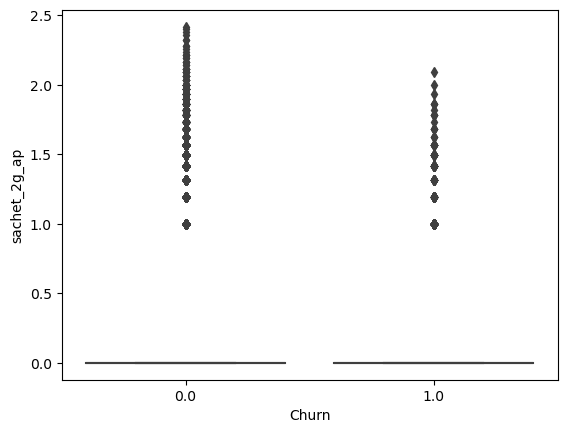

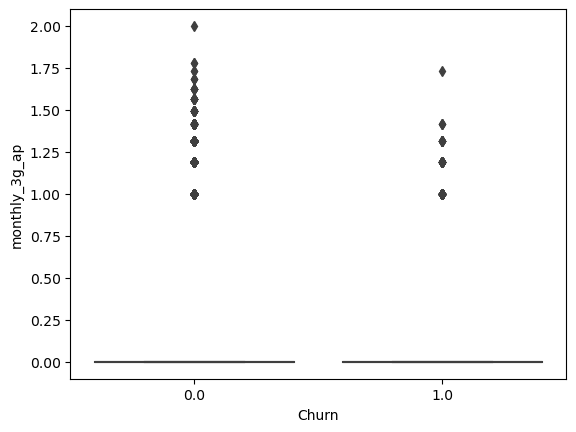

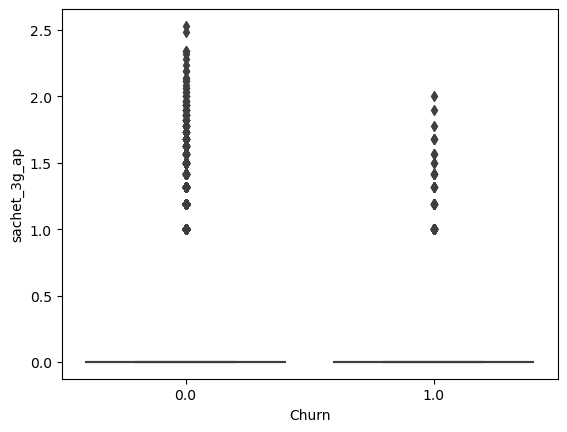

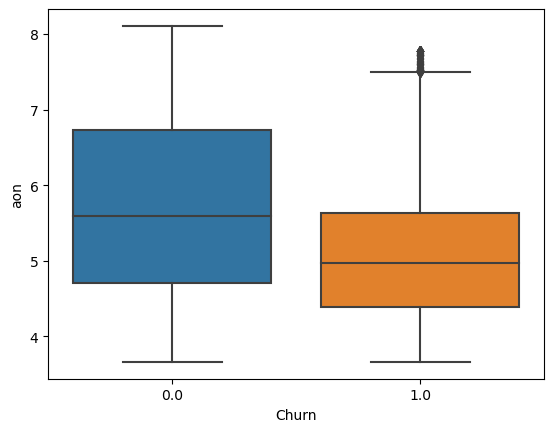

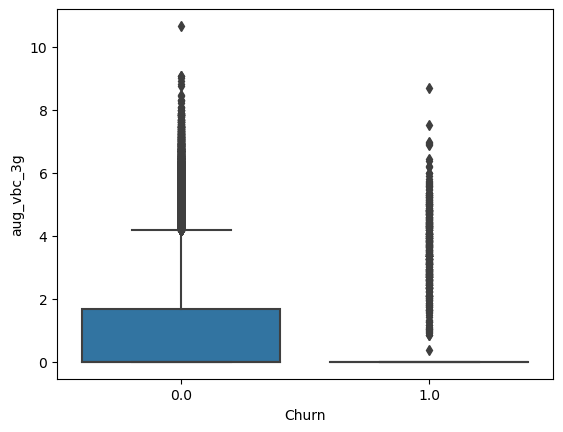

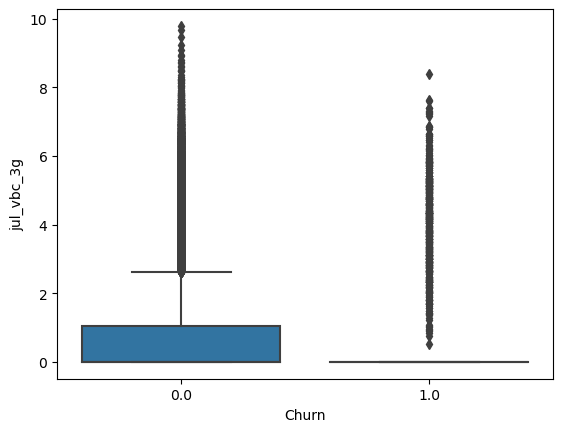

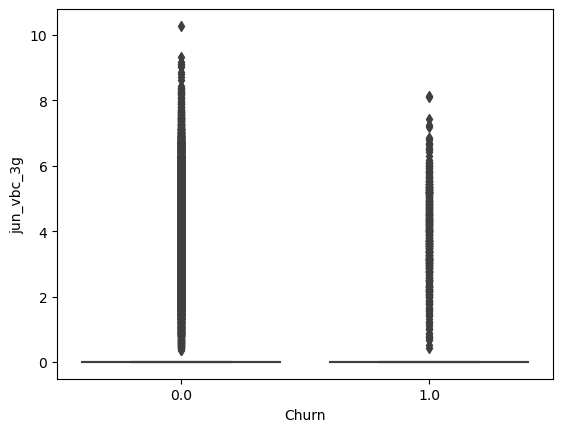

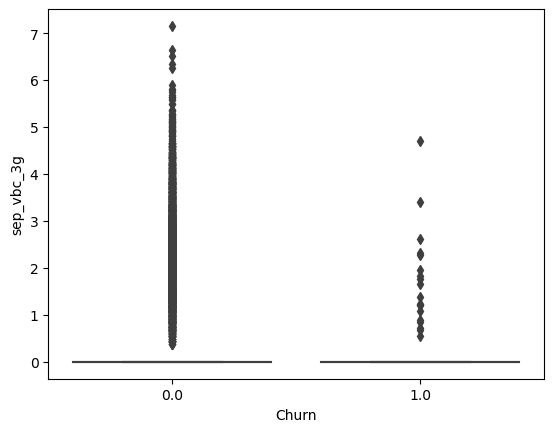

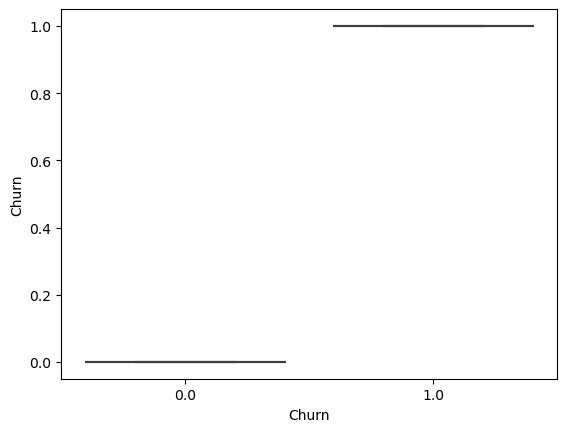

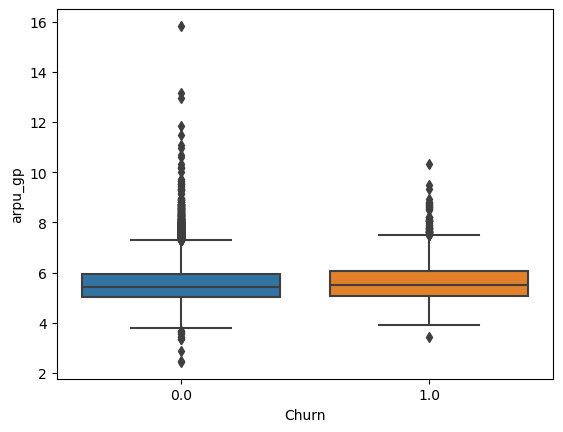

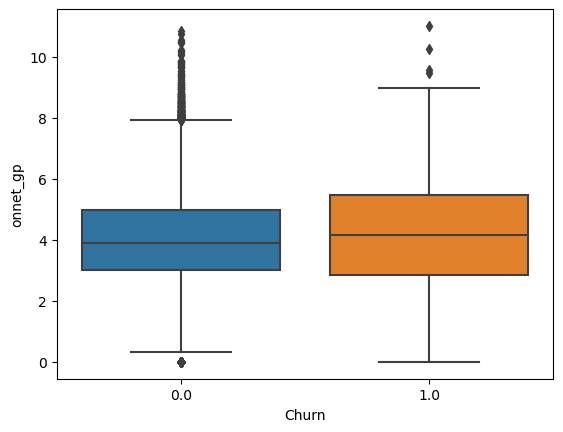

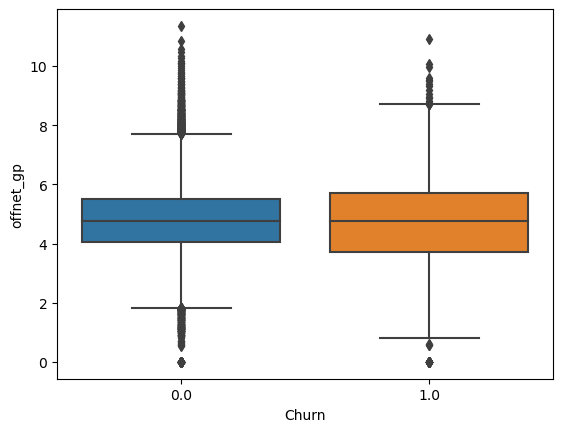

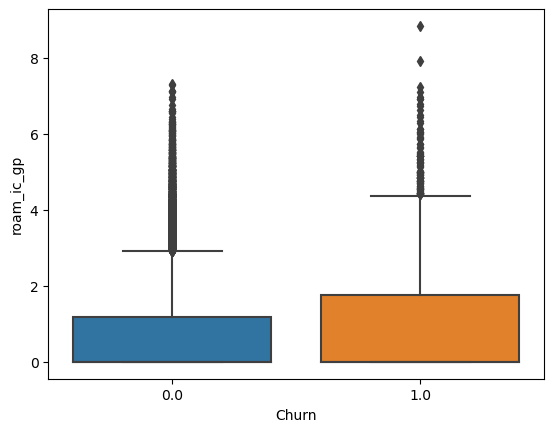

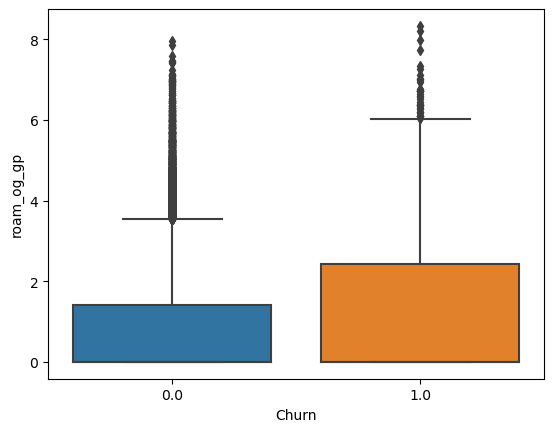

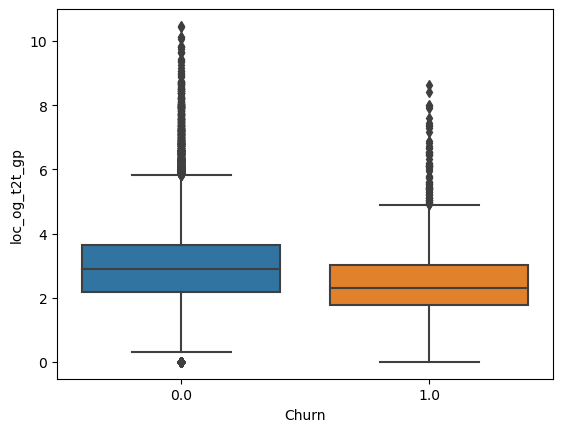

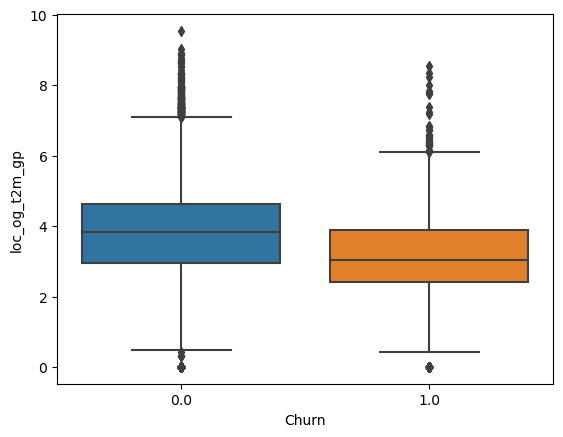

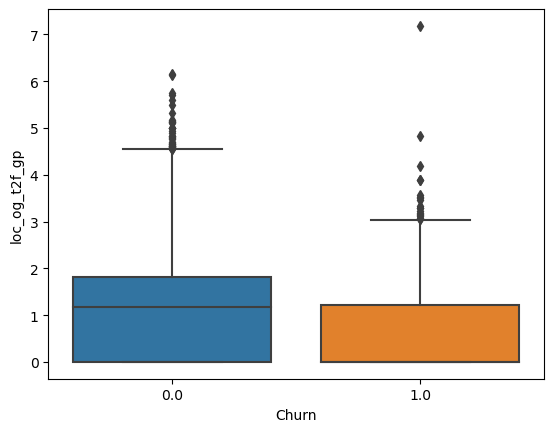

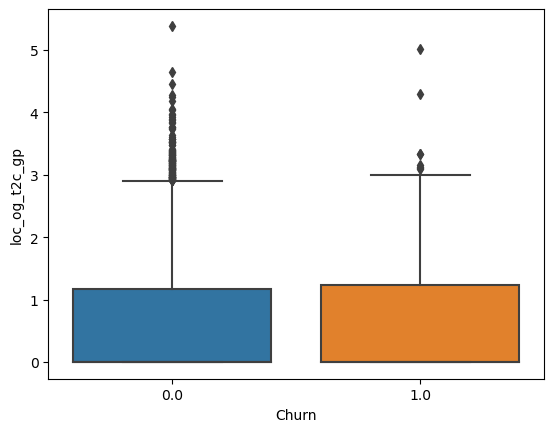

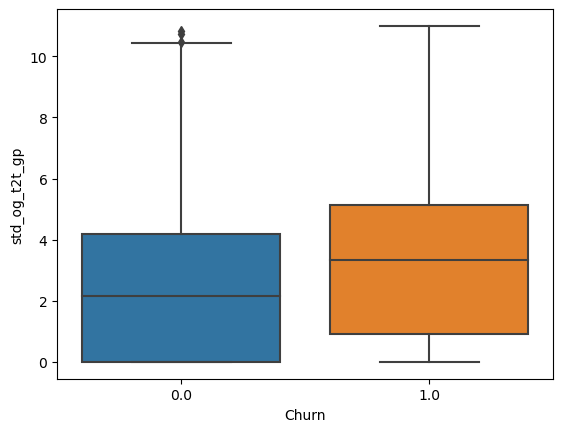

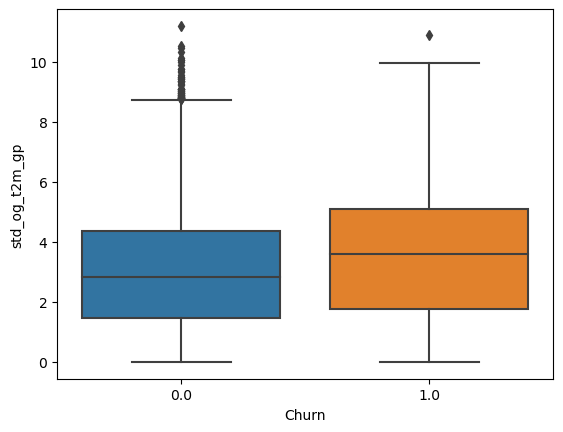

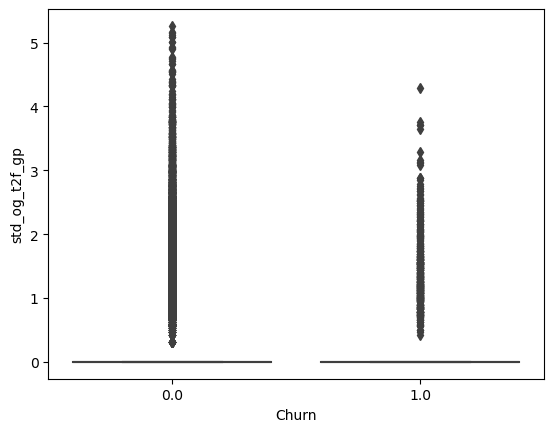

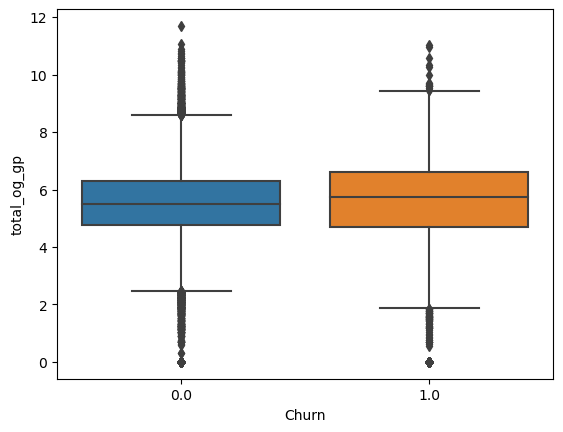

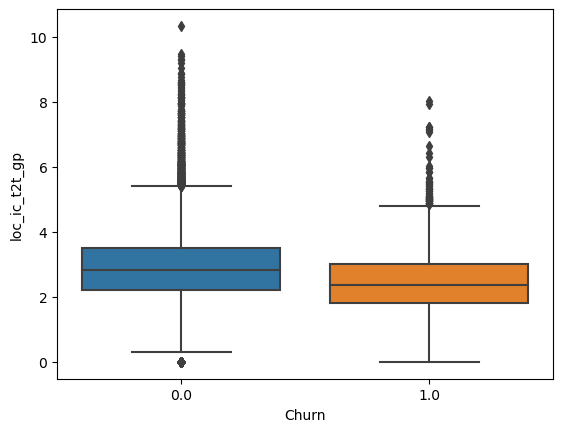

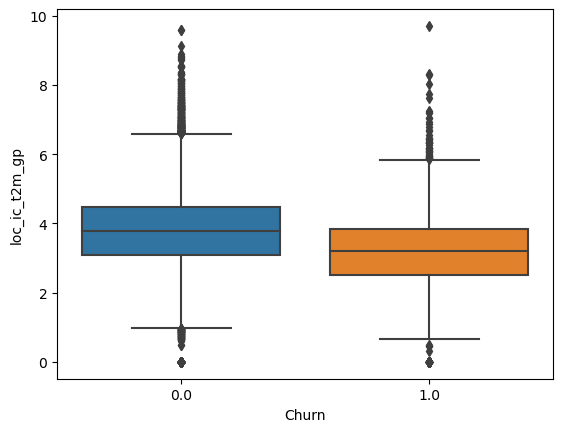

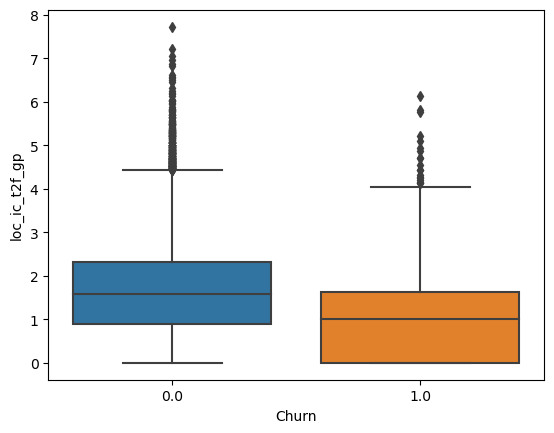

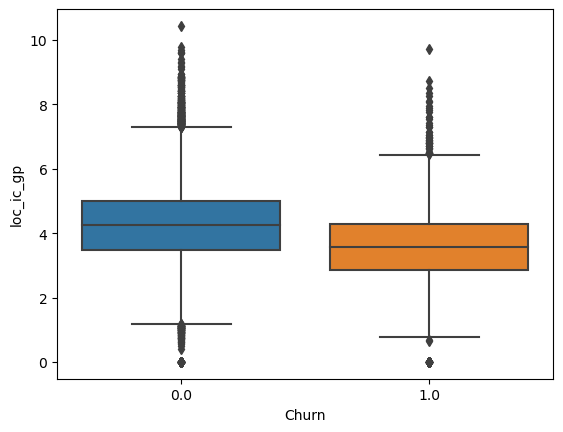

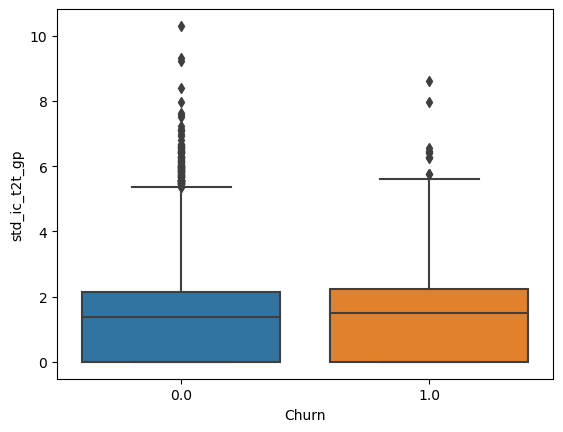

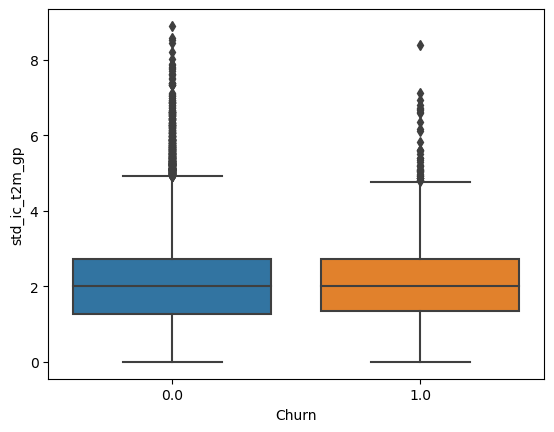

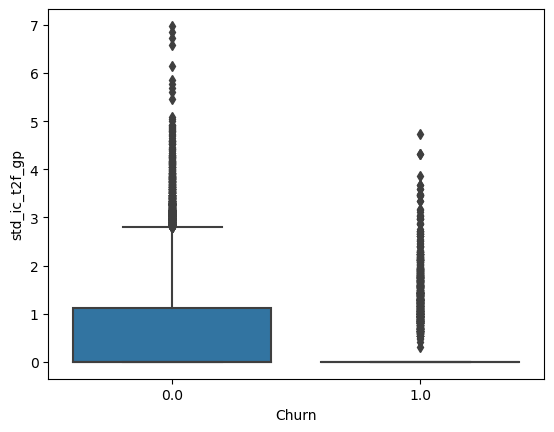

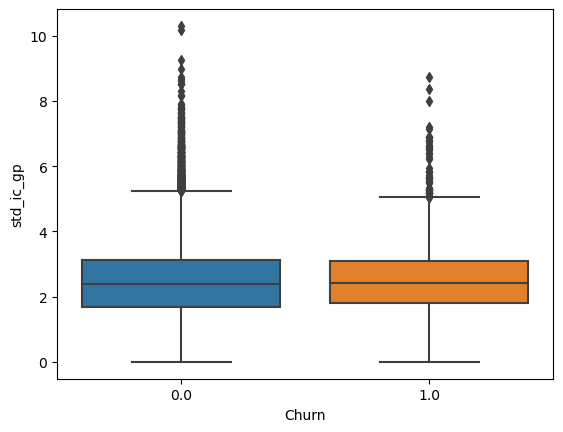

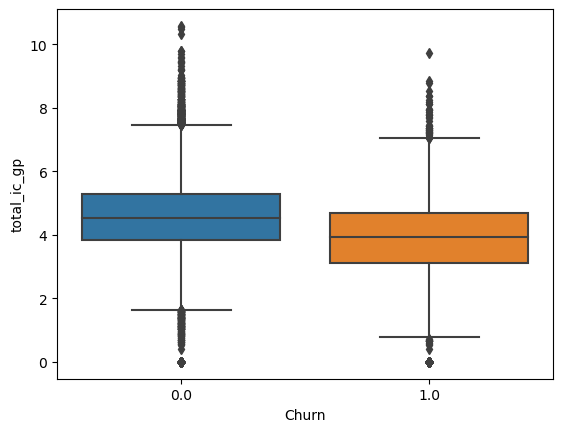

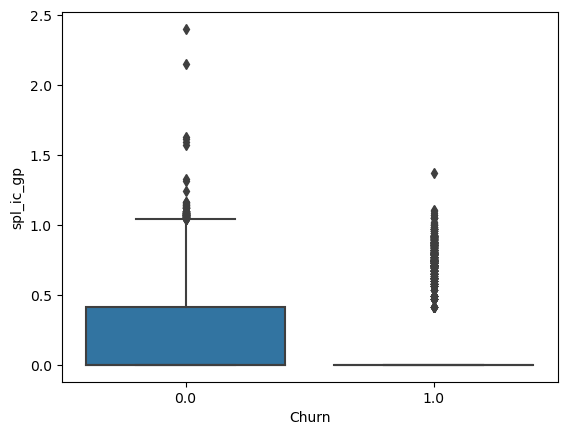

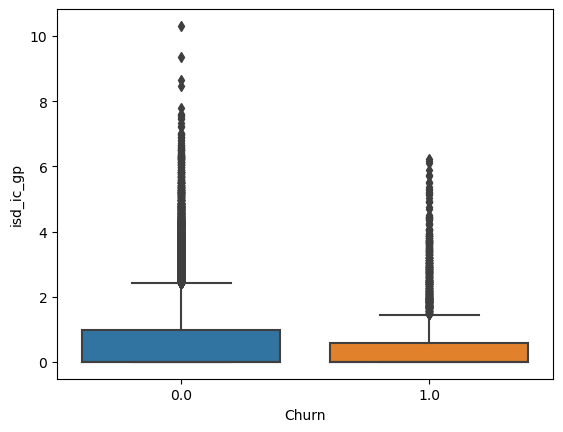

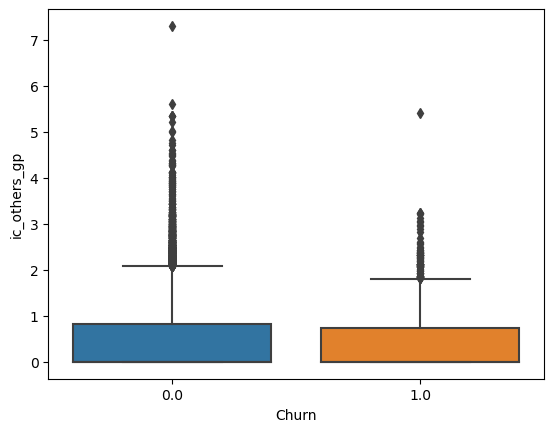

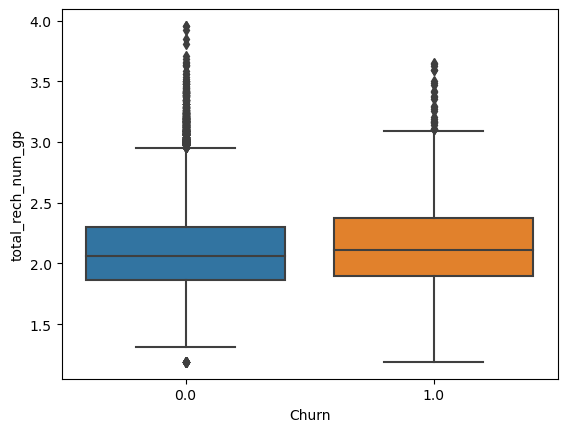

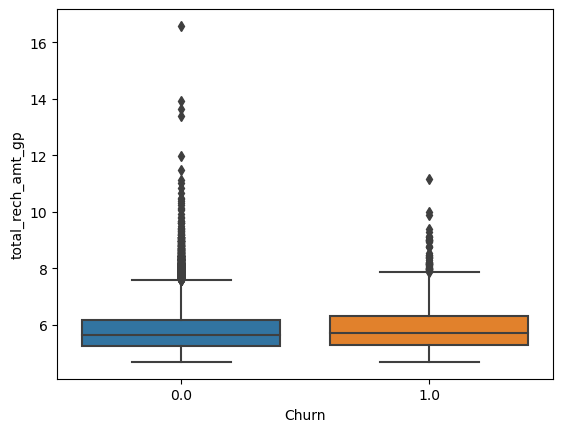

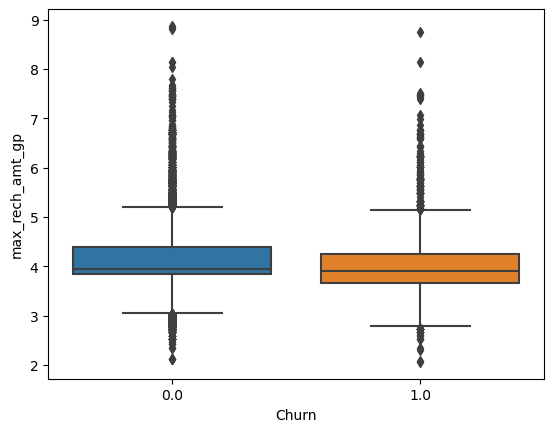

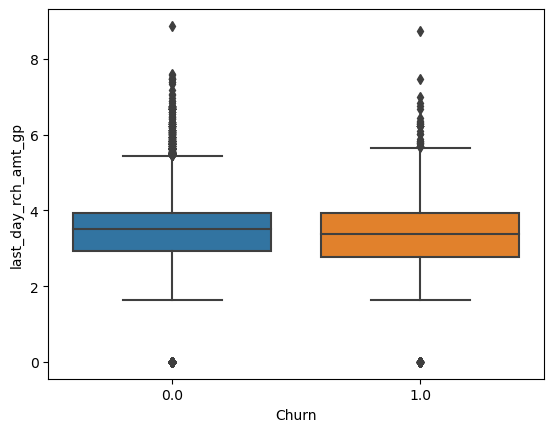

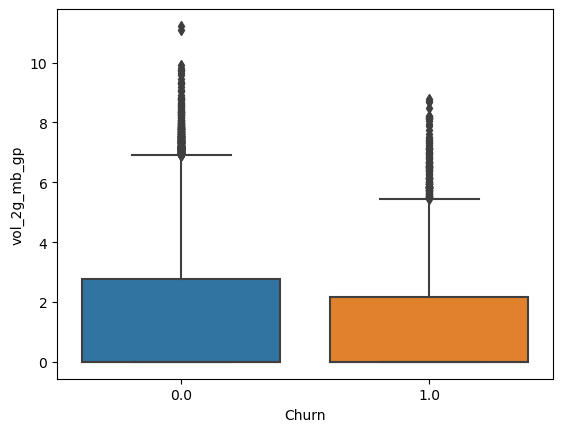

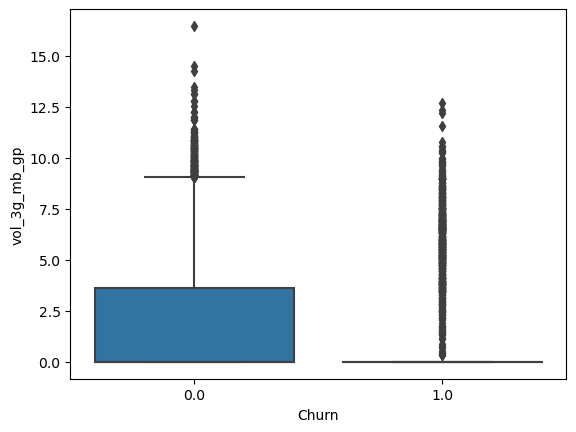

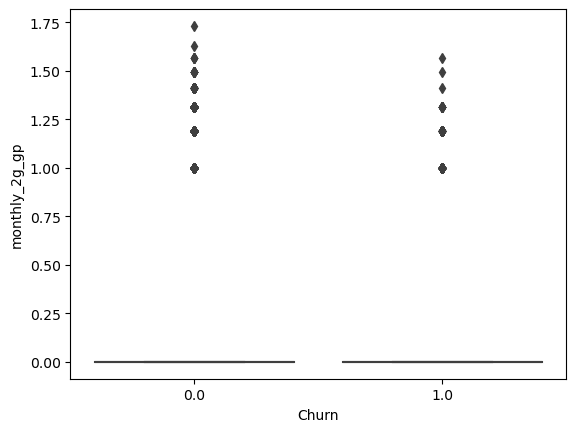

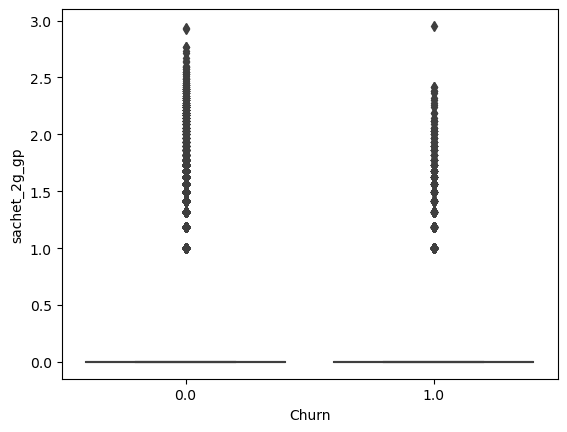

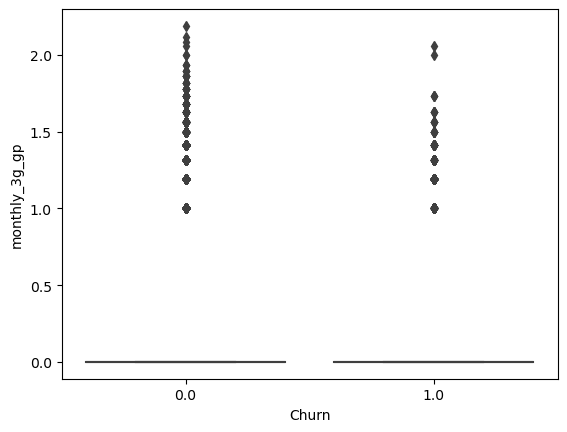

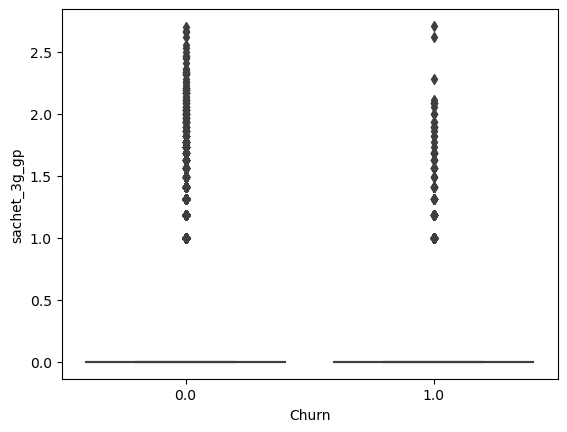

In [89]:
high_value_trans = pd.concat([high_value.drop(['day_last_rech_6', 'day_last_rech_7', 'day_last_rech_8'],axis=1).apply(lambda x: x**(1/4)), high_value[['day_last_rech_6', 'day_last_rech_7', 'day_last_rech_8']]], axis=1)
high_value_trans.dropna(axis=0, inplace=True)
for i in high_value_trans.columns.values:
    if i.__contains__("day_last"):
        continue
    sns.boxplot(data=high_value_trans, y=i, x="Churn")
    plt.show()

In [90]:
X = high_value_trans.drop(labels=["Churn"], axis=1)
y = high_value_trans["Churn"]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

In [92]:
y_train.value_counts(normalize=True)*100

0.0    92.418378
1.0     7.581622
Name: Churn, dtype: float64

In [93]:
y_test.value_counts(normalize=True)*100

0.0    92.421714
1.0     7.578286
Name: Churn, dtype: float64

In [94]:
# SMOTE+TOMEK
from imblearn.combine import SMOTETomek
smt_tmk = SMOTETomek(random_state=45)
X_resampled, y_resampled = smt_tmk.fit_resample(X_train, y_train)
len(X_resampled)

43930

In [95]:
X_resampled.head()

arpu_ap  onnet_ap  offnet_ap  roam_ic_ap  roam_og_ap  loc_og_t2t_ap  \
0  4.171124  4.554866   3.664062    0.000000    0.000000       4.543074   
1  5.320766  4.386646   4.868265    0.000000    0.000000       4.386646   
2  5.507229  2.921911   4.383176    0.000000    0.000000       2.921911   
3  4.162689  3.595159   3.101492    2.442486    2.510612       1.325835   
4  3.933780  3.137965   3.953816    0.000000    0.000000       1.937438   

   loc_og_t2m_ap  loc_og_t2f_ap  loc_og_t2c_ap  std_og_t2t_ap  ...  \
0       3.062466       1.308329            0.0       1.450778  ...   
1       4.444460       3.614002            0.0       0.000000  ...   
2       4.249596       2.560452            0.0       0.000000  ...   
3       1.703950       1.104833            0.0       3.451585  ...   
4       2.489818       1.026433            0.0       3.017076  ...   

   last_day_rch_amt_gp  vol_2g_mb_gp  vol_3g_mb_gp  monthly_2g_gp  \
0             4.472136      3.201924      4.073496            0.0   
1             4.527019      0.000000      0.000000            0.0   
2             3.935979      2.360562      5.584950            1.0   
3             3.851285      0.000000      0.000000            0.0   
4             3.556559      0.000000      0.000000            0.0   

   sachet_2g_gp  monthly_3g_gp  sachet_3g_gp  day_last_rech_6  \
0      1.316074            0.0      1.316074             29.0   
1      0.000000            0.0      0.000000             21.0   
2      0.000000            1.0      0.000000             28.0   
3      0.000000            0.0      0.000000             27.0   
4      0.000000            0.0      0.000000             29.0   

   day_last_rech_7  day_last_rech_8  
0             28.0             25.0  
1             27.0             25.0  
2             30.0             28.0  
3              6.0             30.0  
4             28.0             29.0  

[5 rows x 78 columns]

In [96]:
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0.0, 21965), (1.0, 21965)]


### Dimensionality Reduction

In [97]:
scaler = StandardScaler()
X_scaled_resample = scaler.fit_transform(X_resampled)

In [98]:
pca = PCA(random_state=42)

In [99]:
pca.fit(X_scaled_resample)

PCA(random_state=42)

In [100]:
pca.components_.shape

(78, 78)

In [101]:
pca.explained_variance_ratio_

array([1.85184517e-01, 1.17772620e-01, 6.79301314e-02, 5.38677670e-02,
       4.78411537e-02, 4.06620395e-02, 3.33339106e-02, 2.86909285e-02,
       2.37401701e-02, 2.21366325e-02, 2.16564451e-02, 1.88277158e-02,
       1.76602296e-02, 1.73698744e-02, 1.56161376e-02, 1.44583182e-02,
       1.41811671e-02, 1.33386182e-02, 1.25015329e-02, 1.15566627e-02,
       1.11505550e-02, 1.04008156e-02, 1.02417403e-02, 9.56717477e-03,
       9.41385848e-03, 8.62616033e-03, 8.47147279e-03, 8.25181333e-03,
       8.06001563e-03, 7.76087553e-03, 7.53644541e-03, 7.29933526e-03,
       6.94198114e-03, 6.52474045e-03, 6.39088908e-03, 6.20619914e-03,
       5.96698467e-03, 5.69838946e-03, 5.64146429e-03, 5.07785919e-03,
       4.96816117e-03, 4.85698451e-03, 4.26081532e-03, 4.17784806e-03,
       3.81697913e-03, 3.47849797e-03, 3.27679067e-03, 3.20377837e-03,
       2.94772562e-03, 2.63292479e-03, 2.54468871e-03, 2.34547481e-03,
       2.21053801e-03, 2.05550535e-03, 2.00374559e-03, 1.69672877e-03,
      

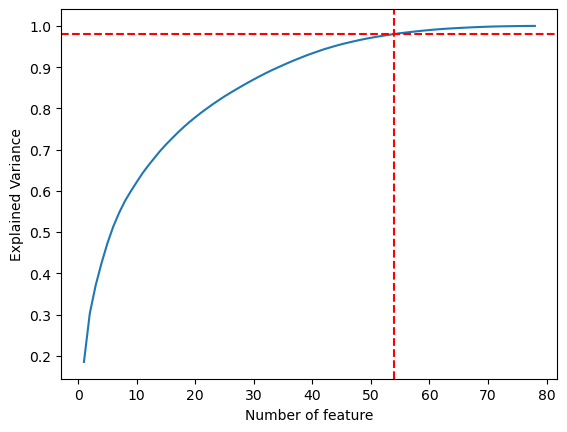

In [102]:
cum_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cum_variance)+1), cum_variance)
plt.xlabel("Number of feature")
plt.ylabel("Explained Variance")
plt.axhline(y=0.98, color="r", linestyle="dashed")
plt.axvline(x=54, color="r", linestyle="dashed")
plt.show()

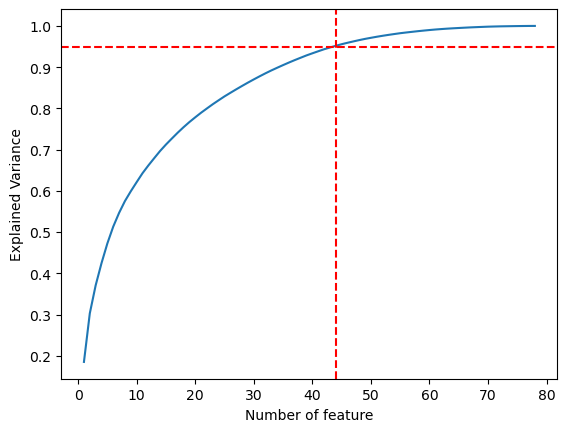

In [103]:
cum_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cum_variance)+1), cum_variance)
plt.xlabel("Number of feature")
plt.ylabel("Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="dashed")
plt.axvline(x=44, color="r", linestyle="dashed")
plt.show()

In [104]:
pca_54 = IncrementalPCA(n_components=54)
X_transformed = pca_54.fit_transform(X_scaled_resample)

In [105]:
X_transformed_df = pd.DataFrame(X_transformed)

In [106]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_transformed_df, y_resampled)

LogisticRegression(random_state=42)

In [107]:
log_reg.coef_

array([[-0.58121724,  0.14207057, -0.08602706,  0.4062668 ,  0.10630051,
         0.00487291,  0.35324667,  0.02487621, -0.00643631, -0.01425867,
        -0.15941683,  0.20930167, -0.22564758,  0.24857115,  0.03023343,
         0.20675167, -0.15075033, -0.71521296, -0.38740631, -0.62260076,
         0.31926913,  0.06797668, -0.03192314,  0.01300104,  0.28965601,
        -0.22348707,  0.03072047,  0.03148633,  0.47520459,  0.0450602 ,
         0.03384874, -0.28545584,  0.30037248, -0.12259588,  0.02941386,
        -0.01281327, -0.39862687,  0.10586459, -0.11670918, -0.06139614,
         0.13609996, -0.27121857, -0.03696557,  0.01222411, -0.0197608 ,
        -0.34683589, -0.06041156,  0.41979333,  0.60848396, -0.26910093,
         0.59273633, -0.16675412,  0.04809362,  0.0603351 ]])

In [108]:
X_test_scaled = scaler.transform(X_test)
X_test_transformed = pca_54.transform(X_test_scaled)
X_test_df = pd.DataFrame(X_test_transformed)
X_test_df.head()

0         1         2         3         4         5         6   \
0 -0.960091  6.006063  5.689023 -0.208366 -1.455467  1.909219 -1.064146   
1 -2.010847  1.725130  0.347293  1.961097 -0.458977 -2.605210 -1.225603   
2  1.884457 -1.625566 -2.786406  1.679079 -4.018630  1.604487 -0.754275   
3  3.407269 -1.786265  1.252685  3.313724  0.100722  2.690223  0.272137   
4 -1.018367 -3.276865 -3.117213 -1.716250 -3.057081 -1.164517 -0.315753   

         7         8         9   ...        44        45        46        47  \
0  2.356731 -1.495361 -0.243931  ...  0.497596 -1.059387 -1.163019 -2.333644   
1 -1.976773  1.543725 -0.482537  ... -0.034280 -0.279375  0.414471 -0.514675   
2 -1.120851 -1.835311 -0.138965  ...  0.007854 -0.211519  0.412139 -0.541557   
3  1.657867 -1.008825  2.613508  ...  0.161790 -0.631230 -0.150503  1.033544   
4 -1.733402 -0.261348 -0.236396  ...  0.379133 -0.013206  0.845247  0.028559   

         48        49        50        51        52        53  
0 -0.544223 -0.287349 -0.966697  0.702380  0.802881  0.147688  
1 -0.140989  0.145412  0.420194 -0.083423 -0.654062  0.078675  
2  0.313895 -0.207127  0.346860 -0.024759  0.075657  0.176675  
3 -0.492747 -0.127336  0.651234 -0.262540  0.242127 -0.103444  
4  0.032889  0.000370 -0.511267  0.428772  0.142040  0.217933  

[5 rows x 54 columns]

Train data Prediction

In [109]:
y_train_pred = log_reg.predict(X_transformed_df)
# y_resampled

In [110]:
confusion_matrix(y_train_pred, y_resampled)

array([[19171,  3181],
       [ 2794, 18784]], dtype=int64)

In [111]:
print(classification_report(y_train_pred, y_resampled))

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87     22352
         1.0       0.86      0.87      0.86     21578

    accuracy                           0.86     43930
   macro avg       0.86      0.86      0.86     43930
weighted avg       0.86      0.86      0.86     43930



In [112]:
accuracy_score(y_train_pred, y_resampled)

0.8639881629865696

In [113]:
precision_score(y_train_pred, y_resampled)

0.8551786933758252

In [114]:
recall_score(y_train_pred, y_resampled)

0.8705162665678006

In [115]:
f1_score(y_train_pred, y_resampled)

0.8627793215901524

Test data prediction

In [116]:
y_pred = log_reg.predict(X_test_df)

In [117]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[8234, 1181],
       [ 137,  635]], dtype=int64)

In [118]:
f1_score(y_true=y_test, y_pred=y_pred)

0.49072642967542507

In [119]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.93      9415
         1.0       0.35      0.82      0.49       772

    accuracy                           0.87     10187
   macro avg       0.67      0.85      0.71     10187
weighted avg       0.94      0.87      0.89     10187



In [120]:
accuracy_score(y_test, y_pred)

0.8706194169038971

In [121]:
precision_score(y_test, y_pred)

0.3496696035242291

In [122]:
recall_score(y_test, y_pred)

0.822538860103627

In [123]:
xgb_cfl = XGBClassifier(n_jobs = -1,objective = 'binary:logistic')
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [124]:
# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5
grid_search = GridSearchCV(estimator=xgb_cfl, param_grid=params, scoring='precision', n_jobs=-1, cv=5, verbose=3)

In [125]:
grid_search.fit(X_transformed_df, y_resampled)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
